This notebook is an EDA for cleansing of soccer data scraped from flashscore.com

The general outline of this notebook is as follows:

1. Understanding the data
2. Missing value and data inconsistency, outliers
3. Data Cleansing
4. Distribution of features
5. Multicollinearity in data
6. Other investigations
7. Basic Processing for feature engineering

In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
import ast
import glob
from ast import literal_eval
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import minimize
from tqdm import tqdm
from statsmodels.stats.diagnostic import het_breuschpagan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro 

In [2]:
def gather_data(PATH, date_column):
    csv_files = glob.glob(os.path.join(PATH, '*.csv'))
    dfs = [pd.read_csv(file) for file in csv_files]
    df = pd.concat(dfs, ignore_index=True, sort=False)
    df[date_column] = pd.to_datetime(df[date_column], format="%d.%m.%Y %H:%M")
    df["ts"] = df[date_column].apply(lambda x: x.timestamp() * 1000)
    df.sort_values(by="ts", ascending=True, inplace=True)
    
    for col in df.columns:
        if col == 'Kick Off':
            continue
        elif col == 'Home 1st Half Goals' or col == 'Home 2nd Half Goals':
            df[col] = pd.to_numeric(df[col], errors='coerce')
            continue
        try:
            df[col] = pd.to_numeric(df[col], errors='raise')
        except:
            print(f"Error occurred while converting column '{col}' to numeric. Continuing...")
            
    
    return df

PATH = r"C:\Users\kiera\Desktop\testing\fs_scraping"
DATE_COLUMN = "Kick Off"
df = gather_data(PATH, DATE_COLUMN)
df_original = df.copy()

C:\Users\kiera\AppData\Local\Temp/ipykernel_33372/962121883.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["ts"] = df[date_column].apply(lambda x: x.timestamp() * 1000)


Error occurred while converting column 'Match ID' to numeric. Continuing...
Error occurred while converting column 'Home Team' to numeric. Continuing...
Error occurred while converting column 'Away Team' to numeric. Continuing...
Error occurred while converting column 'Country' to numeric. Continuing...
Error occurred while converting column 'League' to numeric. Continuing...
Error occurred while converting column 'Home Lineup' to numeric. Continuing...
Error occurred while converting column 'Away Lineup' to numeric. Continuing...
Error occurred while converting column 'Home Goal Times' to numeric. Continuing...
Error occurred while converting column 'Away Goal Times' to numeric. Continuing...
Error occurred while converting column 'Home Team Match Ball Possession' to numeric. Continuing...
Error occurred while converting column 'Away Team Match Ball Possession' to numeric. Continuing...
Error occurred while converting column 'Home Team 1st Half Ball Possession' to numeric. Continuing.

In [3]:
print("No. of rows and columns:", df.shape)
list(df.columns)

No. of rows and columns: (101163, 184)


['Match ID',
 'Home Team',
 'Away Team',
 'Country',
 'League',
 'Kick Off',
 'Home 1st Half Goals',
 'Away 1st Half Goals',
 'Home 2nd Half Goals',
 'Away 2nd Half Goals',
 'Home Lineup',
 'Away Lineup',
 'Home Score',
 'Away Score',
 'Home Goal Times',
 'Away Goal Times',
 'Home Team Match Ball Possession',
 'Away Team Match Ball Possession',
 'Home Team Match Goal Attempts',
 'Away Team Match Goal Attempts',
 'Home Team Match Shots on Goal',
 'Away Team Match Shots on Goal',
 'Home Team Match Shots off Goal',
 'Away Team Match Shots off Goal',
 'Home Team Match Blocked Shots',
 'Away Team Match Blocked Shots',
 'Home Team Match Corner Kicks',
 'Away Team Match Corner Kicks',
 'Home Team Match Offsides',
 'Away Team Match Offsides',
 'Home Team Match Goalkeeper Saves',
 'Away Team Match Goalkeeper Saves',
 'Home Team Match Fouls',
 'Away Team Match Fouls',
 'Home Team Match Red Cards',
 'Away Team Match Red Cards',
 'Home Team Match Yellow Cards',
 'Away Team Match Yellow Cards',
 'H

We have 184 features scraped from over 100k games. We have match id, a unique identifier for each match, basic match info such as country and league that the match is taking place in, kick off time, and a host of statistics that describe each teams performance in terms of, for example, 'Home 1st Half Goals', 'Away 2nd Half Goals',  'Home Team Match Shots on Goal',
'Away Team Match Shots on Goal', etc. We will use these to generate features later before removal. We have a long list of odds data regarding certain match outcomes such as Home Win and BTTS. Many of these are redundant and can be removed. 

Two interesting columns are the lineups and the goal times. These are stored as string-lists. We should be able to use these columns to generate some interesting and informative features, such as player ratings, score-first ratios and average time of first goal scored/conceded, among others.

In [4]:
df.head(5)

,Match ID,Home Team,Away Team,Country,League,Kick Off,Home 1st Half Goals,Away 1st Half Goals,Home 2nd Half Goals,Away 2nd Half Goals,...,Away Team 2nd Half Goal Kicks,Home Team 2nd Half Pass Success %,Away Team 2nd Half Pass Success %,Home Team 2nd Half Total Passes,Away Team 2nd Half Total Passes,Home Team 2nd Half Tackles,Away Team 2nd Half Tackles,Home Team 2nd Half Distance Covered (metres),Away Team 2nd Half Distance Covered (metres),ts
35401,g_1_8YTbqtc7,Shirak Gyumri (Arm),Tre Penne (San),EUROPE,EUROPE: Champions League,2013-07-02 14:00:00,1.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372774e+12
37193,g_1_vcrck9iH,Met. Skopje (Mkd),Qarabag (Aze),EUROPE,EUROPE: Europa League,2013-07-02 16:45:00,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372784e+12
37253,g_1_6V4GxW7B,Sliema (Mlt),Khazar Lenkoran (Aze),EUROPE,EUROPE: Europa League,2013-07-02 16:45:00,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372784e+12
37416,g_1_A3B7vhwa,Narva (Est),Gefle (Swe),EUROPE,EUROPE: Europa League,2013-07-02 17:00:00,0.0,1.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372784e+12
35375,g_1_nPS2r0CD,Lusitanos (And),Streymur (Fai),EUROPE,EUROPE: Champions League,2013-07-02 18:30:00,2.0,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372790e+12


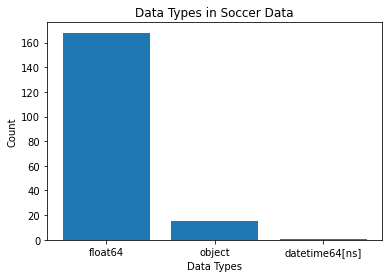

Columns with 'object' dtype:
Match ID
Home Team
Away Team
Country
League
Home Lineup
Away Lineup
Home Goal Times
Away Goal Times
Home Team Match Ball Possession
Away Team Match Ball Possession
Home Team 1st Half Ball Possession
Away Team 1st Half Ball Possession
Home Team 2nd Half Ball Possession
Away Team 2nd Half Ball Possession


In [5]:
data_types = df.dtypes.value_counts()

plt.bar(data_types.index.astype(str), data_types.values)
plt.xlabel('Data Types')
plt.ylabel('Count')
plt.title('Data Types in Soccer Data')
plt.show()

object_cols = df.select_dtypes(include='object').columns.tolist()
print("Columns with 'object' dtype:")
for col in object_cols:
    print(col)

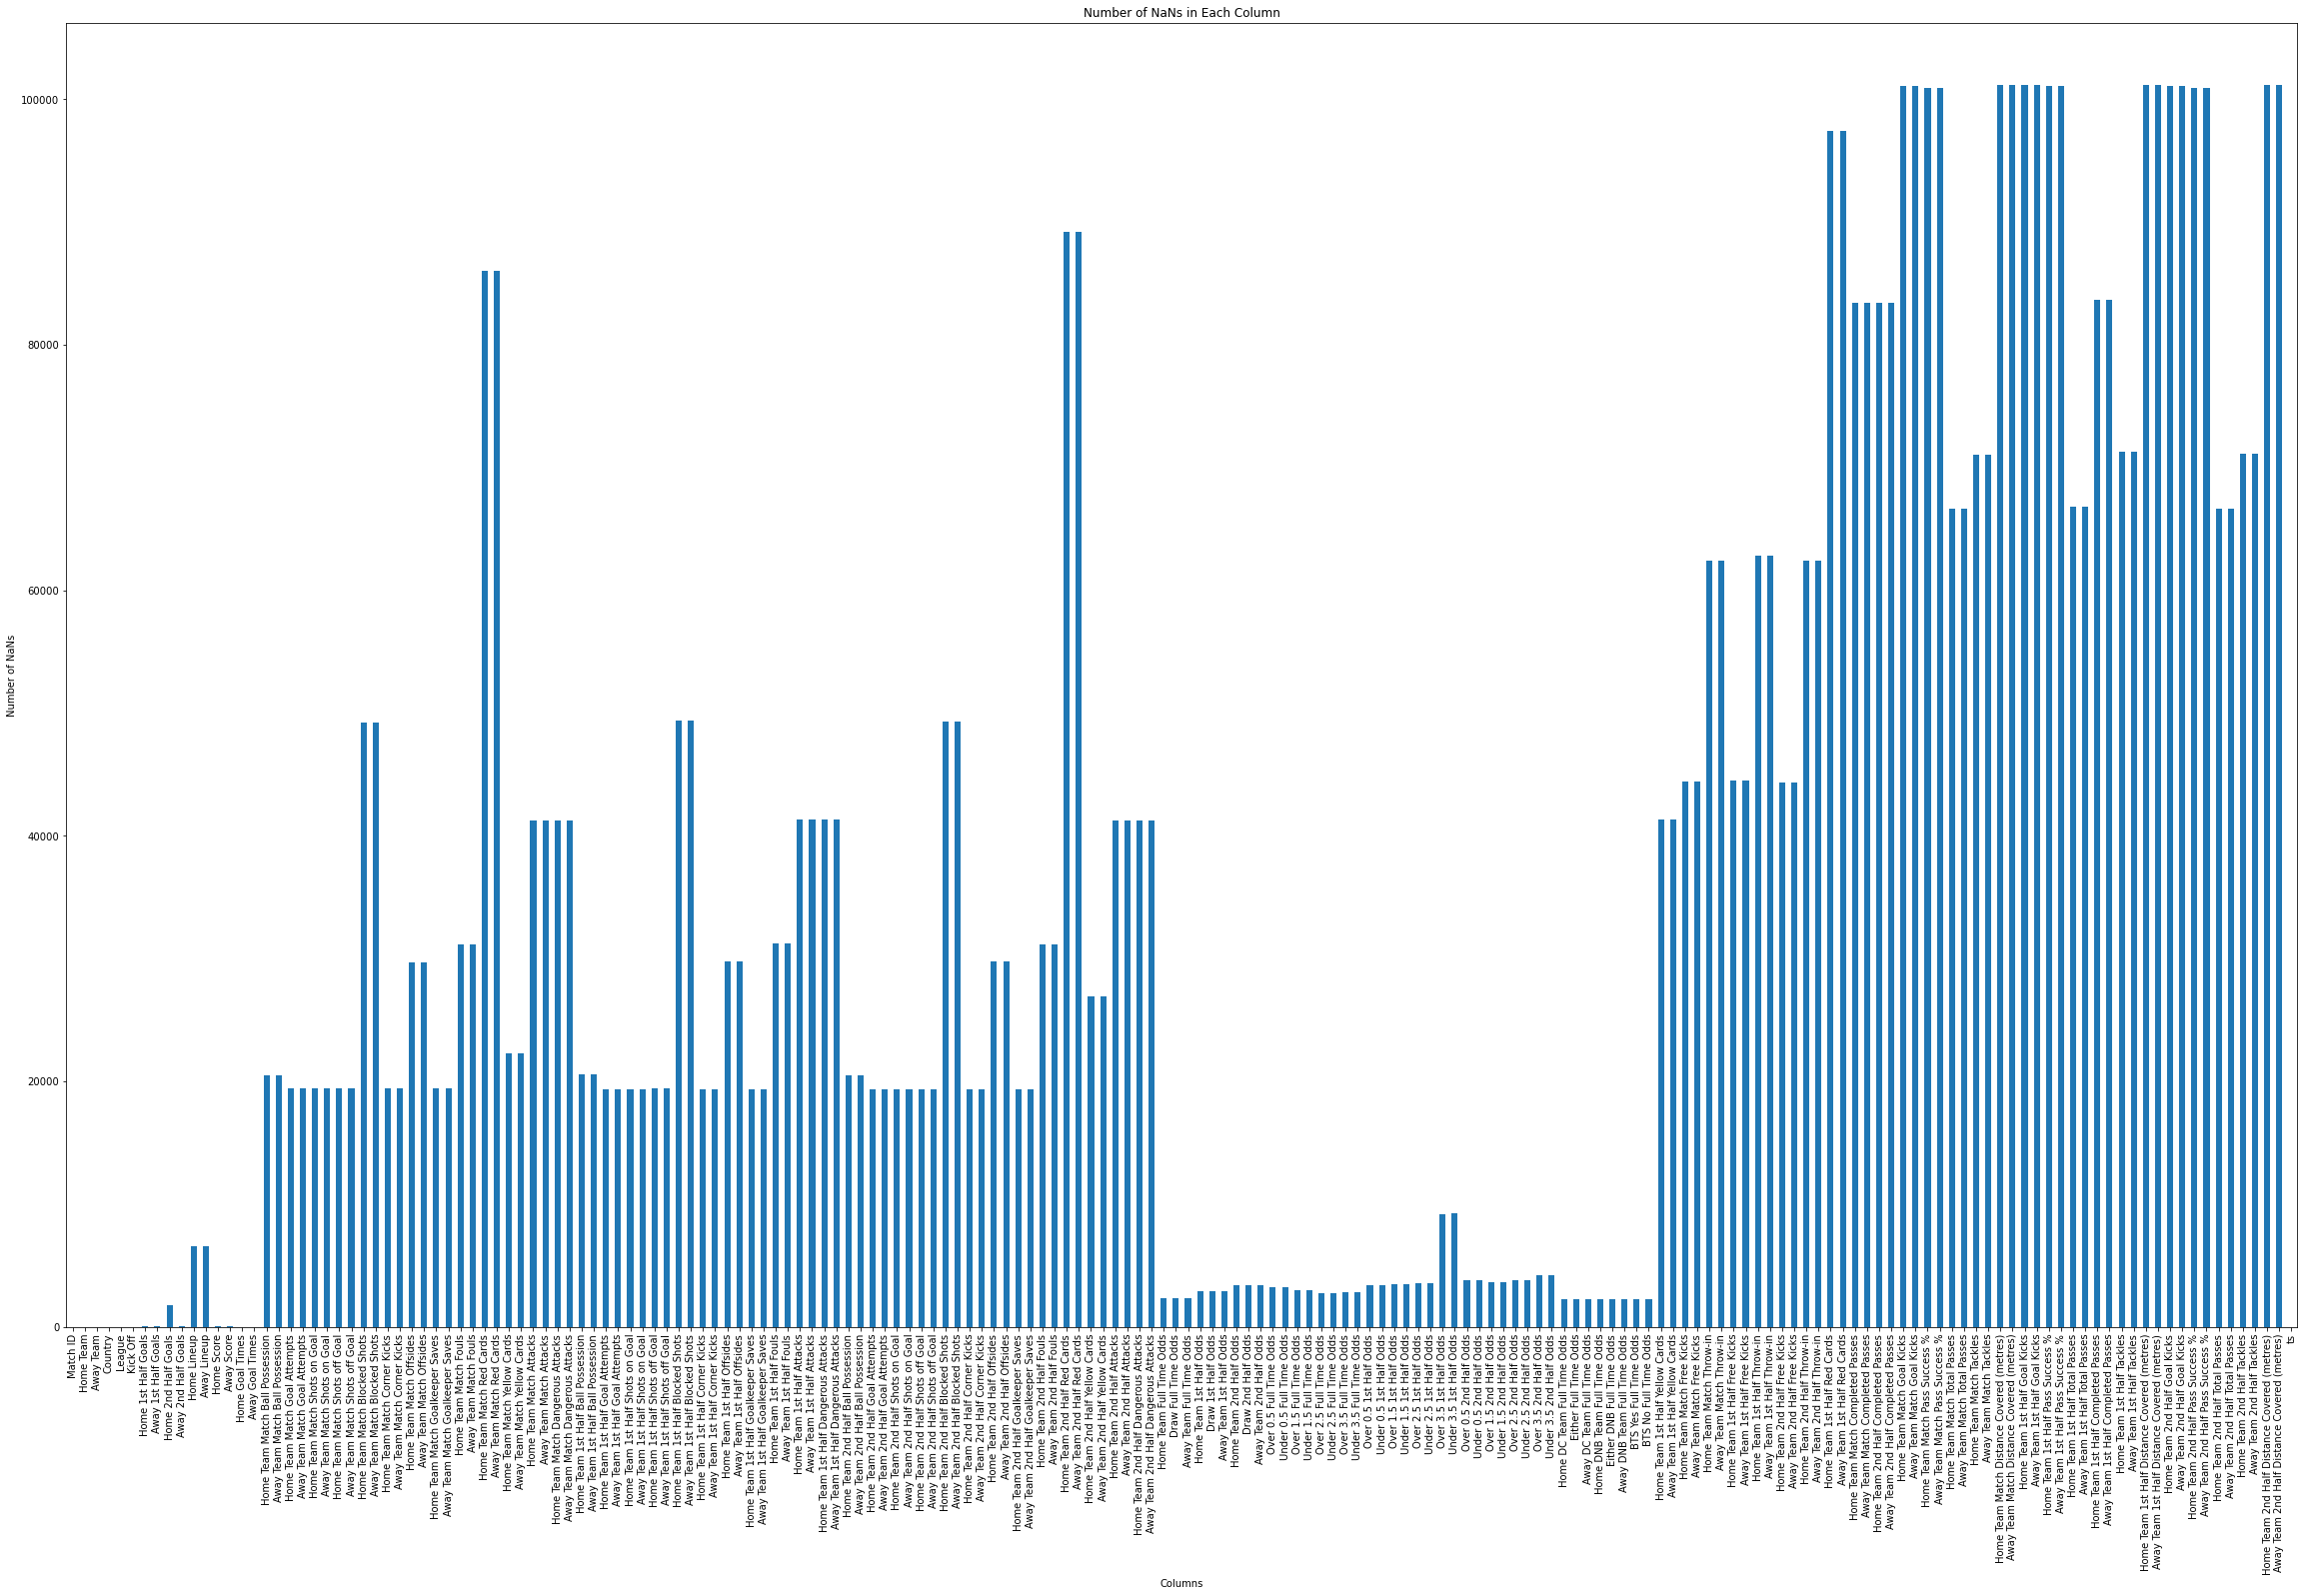

In [6]:
nan_counts = df.isnull().sum()

nan_counts.plot(kind='bar', figsize=(40, 24))
plt.xlabel('Columns')
plt.ylabel('Number of NaNs')
plt.title('Number of NaNs in Each Column')
plt.show()

In [7]:
for col in df.columns:
    nan_sum = df[col].isnull().sum()
    if nan_sum < 10000:
        continue
    print(f"NaN count in {col}: {nan_sum}, {round(nan_sum/len(df)*100,2)}%")

NaN count in Home Team Match Ball Possession: 20479, 20.24%
NaN count in Away Team Match Ball Possession: 20479, 20.24%
NaN count in Home Team Match Goal Attempts: 19398, 19.17%
NaN count in Away Team Match Goal Attempts: 19398, 19.17%
NaN count in Home Team Match Shots on Goal: 19402, 19.18%
NaN count in Away Team Match Shots on Goal: 19402, 19.18%
NaN count in Home Team Match Shots off Goal: 19403, 19.18%
NaN count in Away Team Match Shots off Goal: 19403, 19.18%
NaN count in Home Team Match Blocked Shots: 49228, 48.66%
NaN count in Away Team Match Blocked Shots: 49228, 48.66%
NaN count in Home Team Match Corner Kicks: 19404, 19.18%
NaN count in Away Team Match Corner Kicks: 19404, 19.18%
NaN count in Home Team Match Offsides: 29698, 29.36%
NaN count in Away Team Match Offsides: 29698, 29.36%
NaN count in Home Team Match Goalkeeper Saves: 19400, 19.18%
NaN count in Away Team Match Goalkeeper Saves: 19400, 19.18%
NaN count in Home Team Match Fouls: 31183, 30.82%
NaN count in Away Team

The median missing value percentage for match and ingame statistics is roughly 19%. Higher values are more common in the inplay columns i.e 1st Half and 2nd Half statistics. Some of the advanced metrics such as distance covered and passing completion, have extremely high missing value pecentages. We can do nothing with these columns. We will set a threshold of 21000 and remove any columns with a higher number of missing columns, as we need to keep as many of the match and inplay stats as poissible.


In [8]:
dropped = []
for col in df.columns:
    nan_sum = df[col].isnull().sum()
    if nan_sum <= 21000:
        continue
    else:
        dropped.append(col)
df.drop(dropped, axis = 1, inplace = True)
df

,Match ID,Home Team,Away Team,Country,League,Kick Off,Home 1st Half Goals,Away 1st Half Goals,Home 2nd Half Goals,Away 2nd Half Goals,...,Under 3.5 2nd Half Odds,Home DC Team Full Time Odds,Either Full Time Odds,Away DC Team Full Time Odds,Home DNB Team Full Time Odds,Either DNB Full Time Odds,Away DNB Team Full Time Odds,BTS Yes Full Time Odds,BTS No Full Time Odds,ts
35401,g_1_8YTbqtc7,Shirak Gyumri (Arm),Tre Penne (San),EUROPE,EUROPE: Champions League,2013-07-02 14:00:00,1.0,0.0,2.0,0.0,...,1.2150,5.927500,5.127500,0.510000,0.505000,14.500000,14.500000,2.950000,1.360000,1.372774e+12
37193,g_1_vcrck9iH,Met. Skopje (Mkd),Qarabag (Aze),EUROPE,EUROPE: Europa League,2013-07-02 16:45:00,0.0,0.0,0.0,1.0,...,1.0250,1.590000,1.300000,1.352500,1.240000,1.273333,1.270000,1.855000,1.837500,1.372784e+12
37253,g_1_6V4GxW7B,Sliema (Mlt),Khazar Lenkoran (Aze),EUROPE,EUROPE: Europa League,2013-07-02 16:45:00,0.0,1.0,1.0,0.0,...,1.0450,2.775000,1.162500,1.087500,2.376667,2.373333,2.120000,2.012500,1.710000,1.372784e+12
37416,g_1_A3B7vhwa,Narva (Est),Gefle (Swe),EUROPE,EUROPE: Europa League,2013-07-02 17:00:00,0.0,1.0,0.0,2.0,...,1.0700,3.950000,1.076667,0.696667,4.023333,4.016667,2.876667,2.020000,1.723333,1.372784e+12
35375,g_1_nPS2r0CD,Lusitanos (And),Streymur (Fai),EUROPE,EUROPE: Champions League,2013-07-02 18:30:00,2.0,0.0,0.0,2.0,...,1.0450,2.097500,1.222500,1.177500,1.666667,1.500000,1.643333,1.770000,1.926667,1.372790e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7249,g_1_WzTCFYOk,Guangzhou City,Cangzhou,CHINA,CHINA: Super League,2022-12-31 07:00:00,0.0,4.0,1.0,0.0,...,1.0700,2.071667,1.216667,1.215000,1.832000,1.074000,1.540000,1.586667,2.265000,1.672470e+12
7310,g_1_jwqEDCg2,Shanghai Port,Changchun Yatai,CHINA,CHINA: Super League,2022-12-31 07:00:00,4.0,0.0,0.0,0.0,...,1.1675,1.015000,1.053333,6.450000,5.706000,6.604000,2.810000,2.052000,1.704000,1.672470e+12
7544,g_1_CnpAEhvd,Zhejiang Professional,Wuhan FC,CHINA,CHINA: Super League,2022-12-31 07:00:00,3.0,0.0,1.0,0.0,...,1.1800,2.816000,5.006000,5.304000,8.752500,10.000000,7.250000,2.912000,1.376000,1.672470e+12
7356,g_1_08Q4zz1F,Wuhan Three Towns,Tianjin Jinmen Tiger,CHINA,CHINA: Super League,2022-12-31 07:00:00,3.0,0.0,3.0,0.0,...,NaN,1.220000,1.230000,2.100000,1.220000,1.230000,2.100000,1.520000,2.360000,1.672470e+12


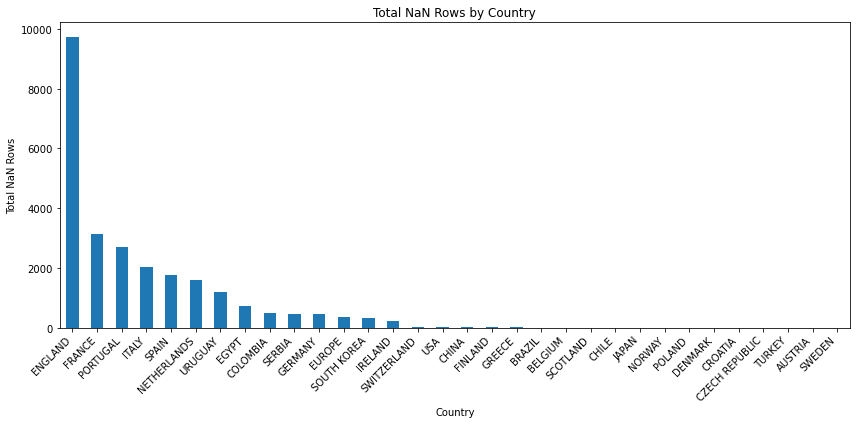

In [9]:
grouped_country = df.groupby('Country')
nan_counts_country = grouped_country.apply(lambda x: x.isnull().any(axis=1).sum())
nan_counts_country_sorted = nan_counts_country.sort_values(ascending=False)
nan_counts_country_sorted.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Country')
plt.ylabel('Total NaN Rows')
plt.title('Total NaN Rows by Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

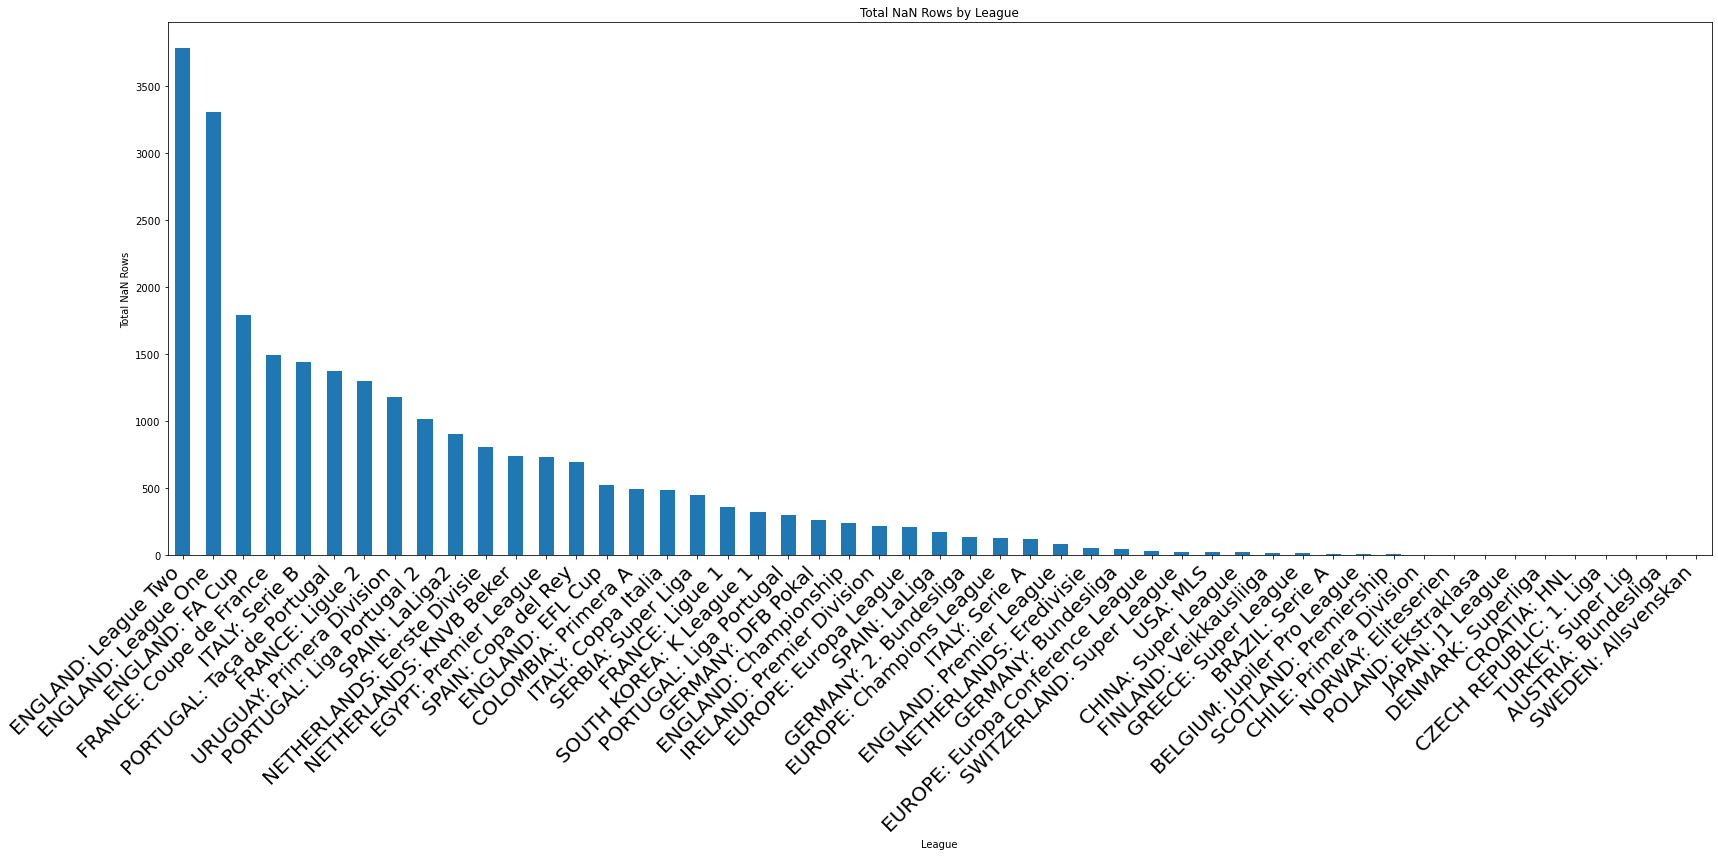

In [10]:
grouped_league = df.groupby('League')
nan_counts_league = grouped_league.apply(lambda x: x.isnull().any(axis=1).sum())
nan_counts_league_sorted = nan_counts_league.sort_values(ascending=False)
nan_counts_league_sorted.plot(kind='bar', figsize=(24, 12))
plt.xlabel('League')
plt.ylabel('Total NaN Rows')
plt.title('Total NaN Rows by League')
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.tight_layout()
plt.show()

It seems clear that a lot of the missing values are due to a lack of coverage on the source website. A lot of these leagues were scraped in bundles using threading, and scraping the same seasons for several different league probably resulted in seasons being scraped that simply weren't covered by flashscore.

**Inconsistencies**

Before dealing with the remaining missing data we will look through our dataframe for inconsistencies. Here are a few facts about our data that should be faithfully reflected in its distribution:

Our numeric data should range from 0 to n where $n \in \mathbb{N}$. 
Our odds data columns should range from 0 to 1. 
Another thing to note is that the 1st and 2nd half totals for each match statistic should add up to the match total. 
The implied probabilities for each related event, eg BTTS Yes and No, home, draw and away Win should sum to roughly 105%. These can easily be calculated from the corresponding odds columns.

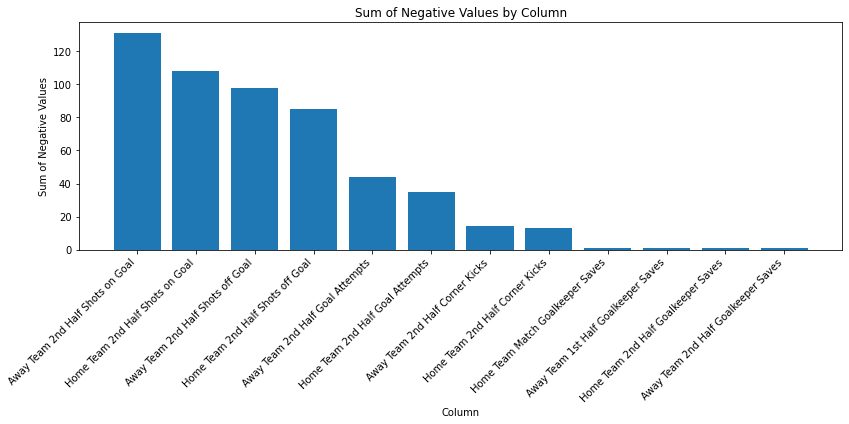

Column: Home Team Match Goalkeeper Saves, Sum of Negative Values: 1
Column: Away Team 1st Half Goalkeeper Saves, Sum of Negative Values: 1
Column: Home Team 2nd Half Goal Attempts, Sum of Negative Values: 35
Column: Away Team 2nd Half Goal Attempts, Sum of Negative Values: 44
Column: Home Team 2nd Half Shots on Goal, Sum of Negative Values: 108
Column: Away Team 2nd Half Shots on Goal, Sum of Negative Values: 131
Column: Home Team 2nd Half Shots off Goal, Sum of Negative Values: 85
Column: Away Team 2nd Half Shots off Goal, Sum of Negative Values: 98
Column: Home Team 2nd Half Corner Kicks, Sum of Negative Values: 13
Column: Away Team 2nd Half Corner Kicks, Sum of Negative Values: 14
Column: Home Team 2nd Half Goalkeeper Saves, Sum of Negative Values: 1
Column: Away Team 2nd Half Goalkeeper Saves, Sum of Negative Values: 1


In [11]:
negs = []
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        neg_sum = df[col].lt(0).sum() 
        if neg_sum > 0:
            negs.append((col, neg_sum))

negs_sorted = sorted(negs, key=lambda x: x[1], reverse=True)
cols_sorted, sums_sorted = zip(*negs_sorted)

plt.figure(figsize=(12, 6))
plt.bar(cols_sorted, sums_sorted)
plt.xlabel('Column')
plt.ylabel('Sum of Negative Values')
plt.title('Sum of Negative Values by Column')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


negs = []
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        neg_sum = df[col].lt(0).sum()  
        if neg_sum > 0:
            print(f"Column: {col}, Sum of Negative Values: {neg_sum}")


Negative values constitute a small portion of the overall data but will still need to be dealt with.

In [12]:
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        if "Odds" in col:
            break
        if not "1st Half" in col:
            continue
        else:
            if not "Goals" in col:
                col_p = col.replace("1st Half", "")
                col_2 = col.replace("1st", "2nd")
                col_m = col.replace("1st Half", "Match")
            else:
                col_p = col.replace("1st Half", "")
                col_2 = col.replace("1st", "2nd")
                col_m = col.replace("Team 1st Half Goals", "Score")
            mismatches = len(df[(df[col] + df[col_2] != df[col_m])])
            print(f"Total number of mismatches for {col_p}: {mismatches}")

Total number of mismatches for Home  Goals: 57666
Total number of mismatches for Away  Goals: 49660
Total number of mismatches for Home Team  Goal Attempts: 19890
Total number of mismatches for Away Team  Goal Attempts: 19879
Total number of mismatches for Home Team  Shots on Goal: 19796
Total number of mismatches for Away Team  Shots on Goal: 19809
Total number of mismatches for Home Team  Shots off Goal: 19825
Total number of mismatches for Away Team  Shots off Goal: 19809
Total number of mismatches for Home Team  Corner Kicks: 19786
Total number of mismatches for Away Team  Corner Kicks: 19784
Total number of mismatches for Home Team  Goalkeeper Saves: 19751
Total number of mismatches for Away Team  Goalkeeper Saves: 19737


We need to do processing on the possession variables before investigating further. It is also likely that nan values are showing up here, but we don't know how many inconsistencies they account for yet. We will impute missing values, process possession, and come back to this. Let's look at our odds data for inconsistencies.

Mean Bookmakers Margin Match Result: 1.0642162194588534
Bookmakers Margin STD Match Result: 0.020928903430018686


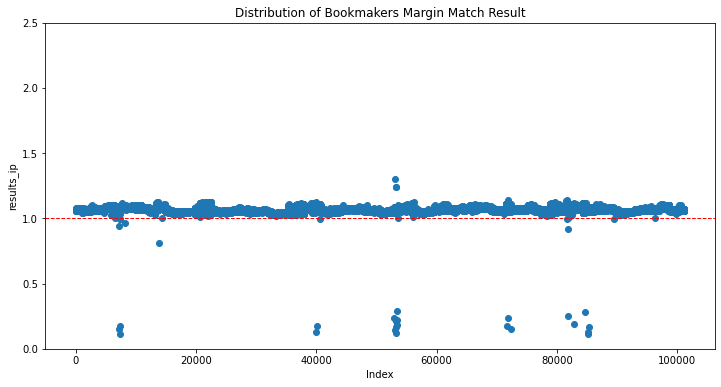

In [13]:
results_ip = 1/df['Home Team Full Time Odds'] + 1/df['Away Team Full Time Odds'] + 1/df['Draw Full Time Odds']

print(f"Mean Bookmakers Margin Match Result: {results_ip.replace([np.inf, -np.inf], np.nan).dropna().mean()}")
print(f"Bookmakers Margin STD Match Result: {results_ip.replace([np.inf, -np.inf], np.nan).dropna().std()}")

plt.figure(figsize=(12, 6))
plt.scatter(df.index, (results_ip))
plt.xlabel('Index')
plt.ylabel('results_ip')
plt.title('Distribution of Bookmakers Margin Match Result')
plt.ylim(0, 2.5)
plt.axhline(y=1.0, color='red', linestyle='--', linewidth=1) 
plt.show()

The vast majority of the Home draw and away result values fall on a nice tight line. We expected roughly 105% mean with a nice tight standard deviation. I think it is obvious that this std should be tighter and is being affected by a small minority of incorrect values. 

Mean Bookmakers Margin Over/Under 2.5: 1.0581577518992165
Bookmakers Margin STD Over/Under 2.5: 0.012907963725207203


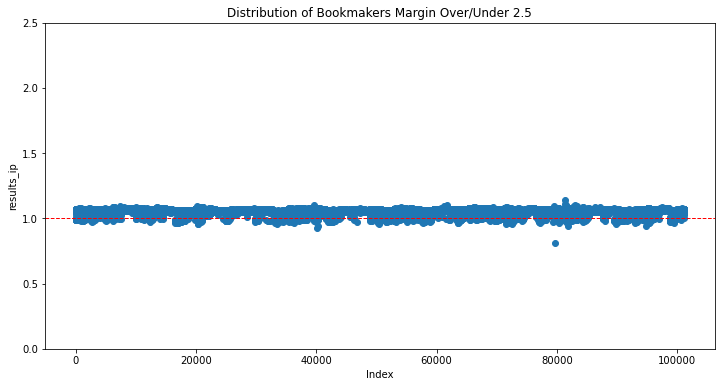

In [14]:
o25_ip = 1/df['Over 2.5 Full Time Odds'] + 1/df['Under 2.5 Full Time Odds'] 

print(f"Mean Bookmakers Margin Over/Under 2.5: {o25_ip.replace([np.inf, -np.inf], np.nan).dropna().mean()}")
print(f"Bookmakers Margin STD Over/Under 2.5: {o25_ip.replace([np.inf, -np.inf], np.nan).dropna().std()}")

plt.figure(figsize=(12, 6))
plt.scatter(df.index, o25_ip)
plt.xlabel('Index')
plt.ylabel('results_ip')
plt.title('Distribution of Bookmakers Margin Over/Under 2.5')
plt.ylim(0, 2.5)
plt.axhline(y=1.0, color='red', linestyle='--', linewidth=1) 
plt.show()

There are no extreme outliers here, but more rows lie beneath 1.0 than in the match result plot. 

Mean Bookmakers Margin BTTS: 1.067926050103098
Bookmakers Margin STD BTTS: 0.028879669636664378


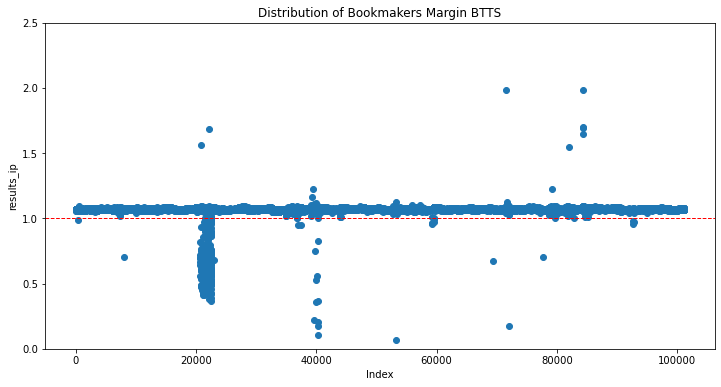

In [15]:
btts_ip = 1/df['BTS Yes Full Time Odds'] + 1/df['BTS No Full Time Odds'] 

print(f"Mean Bookmakers Margin BTTS: {btts_ip.replace([np.inf, -np.inf], np.nan).dropna().mean()}")
print(f"Bookmakers Margin STD BTTS: {btts_ip.replace([np.inf, -np.inf], np.nan).dropna().std()}")


plt.figure(figsize=(12, 6))
plt.scatter(df.index, btts_ip)
plt.xlabel('Index')
plt.ylabel('results_ip')
plt.title('Distribution of Bookmakers Margin BTTS')
plt.ylim(0, 2.5)
plt.axhline(y=1.0, color='red', linestyle='--', linewidth=1) 
plt.show()

Before we discuss these plots, a brief note on how we scraped this data. The odds data for each is listed alongside the bookmaker offering those odds. We collect each odds listing and process them to return an average of several or at least one bookmaker. This does not seem to have created any problems with the match result odds data. The average bookies premium sits at 6.4% with a tight std which will have been affected by a small number of extreme outliers. For the other two markets, over/under 2.5 and btts, particularly over/under 2.5, we seem to have a problem. There appears to be a large number of matches where the total market is less than 1.0, implying a great deal of arbitrage opportunties! But we know this is not the case. We may have to discard this data and rethink our data collection. 

There is a large section of the BTTS plot which has total IP less than 1. They seem to be clustered together which may indicate that they belong to the same league or country. We will investigate this further now. The following plots show the number of inconsistent odds data rows by country along with the percentage of games from that country which they account for.


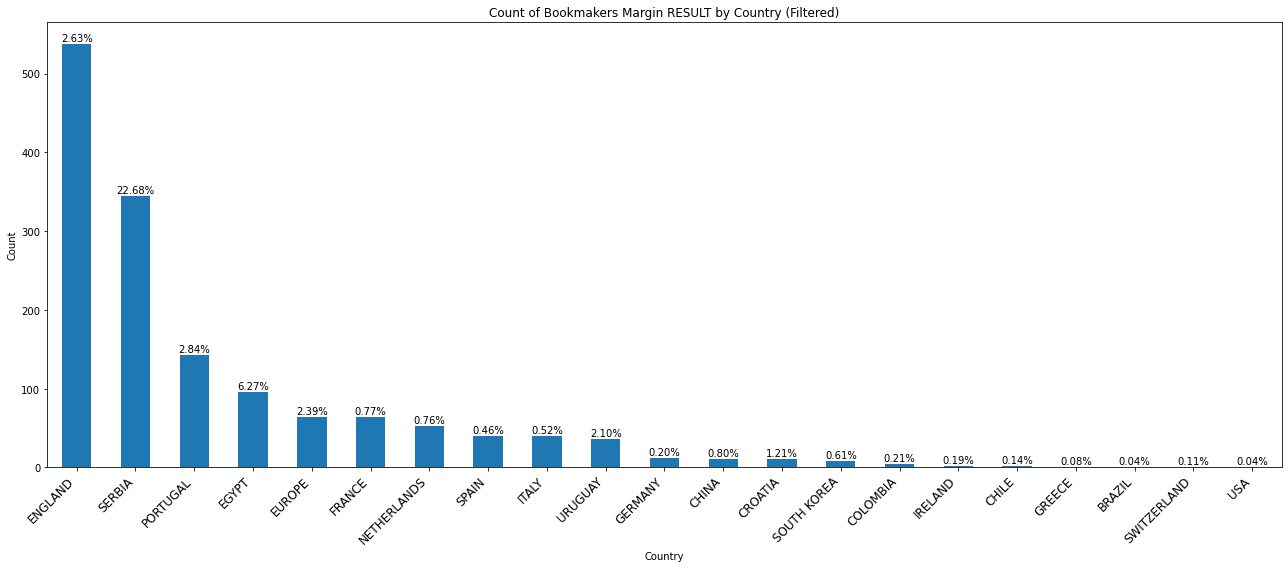

In [16]:
filtered_results_ip = results_ip[(results_ip < 1) | (results_ip > 1.1)]
countries = df.loc[filtered_results_ip.index, 'Country']
count_by_country = countries.value_counts()
percentages = [(count / df['Country'].value_counts()[country]) * 100 for country, count in count_by_country.items()]

plt.figure(figsize=(18, 8))
ax = count_by_country.plot(kind='bar')
count_by_country.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Bookmakers Margin RESULT by Country (Filtered)')
plt.xticks(rotation=45, ha='right', fontsize=12)
for i, v in enumerate(count_by_country):
    ax.text(i, v + 1, f'{percentages[i]:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

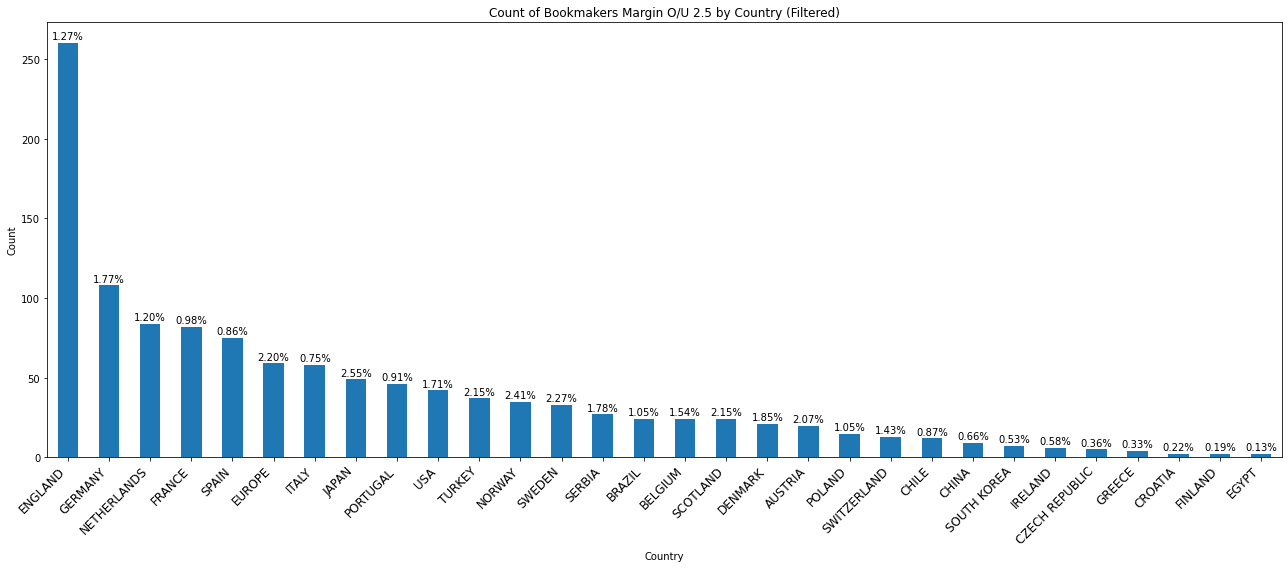

In [17]:
filtered_o25_ip = o25_ip[(o25_ip < 1) | (o25_ip > 1.1)]
countries = df.loc[filtered_o25_ip.index, 'Country']
count_by_country = countries.value_counts()
percentages = [(count / df['Country'].value_counts()[country]) * 100 for country, count in count_by_country.items()]

plt.figure(figsize=(18, 8))
ax = count_by_country.plot(kind='bar')
count_by_country.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Bookmakers Margin O/U 2.5 by Country (Filtered)')
plt.xticks(rotation=45, ha='right', fontsize=12)
for i, v in enumerate(count_by_country):
    ax.text(i, v + 1, f'{percentages[i]:.2f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()

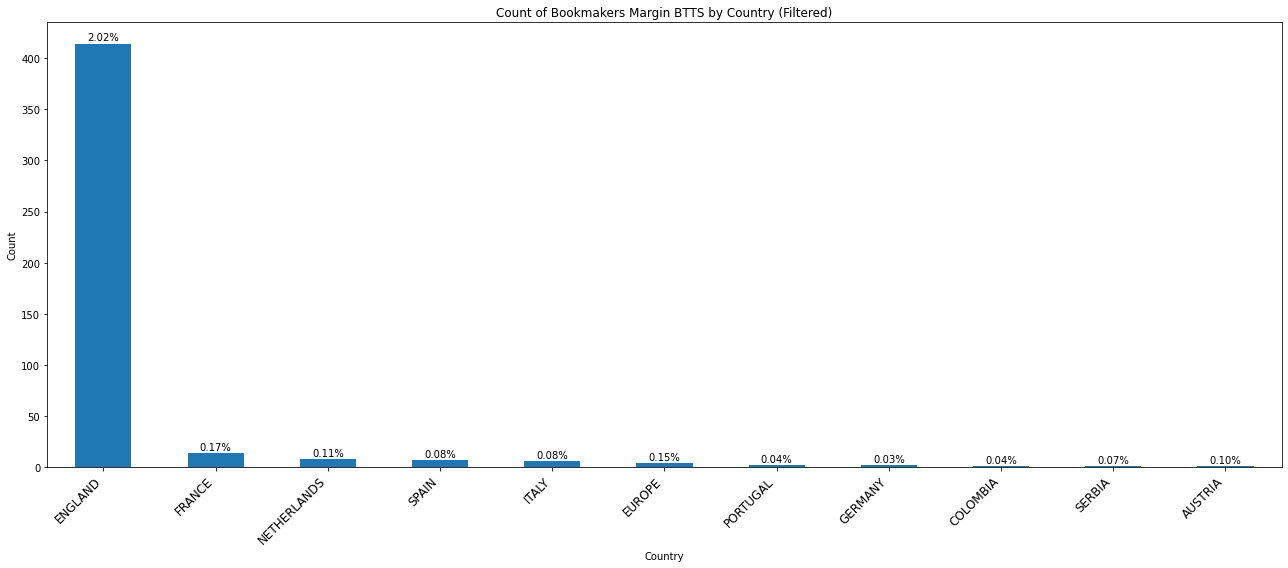

In [18]:
filtered_btts_ip = btts_ip[(btts_ip < 1) | (btts_ip > 1.1)]
countries = df.loc[filtered_btts_ip.index, 'Country']
count_by_country = countries.value_counts()
percentages = [(count / df['Country'].value_counts()[country]) * 100 for country, count in count_by_country.items()]

plt.figure(figsize=(18, 8))
ax = count_by_country.plot(kind='bar')
count_by_country.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Bookmakers Margin BTTS by Country (Filtered)')
plt.xticks(rotation=45, ha='right', fontsize=12)
for i, v in enumerate(count_by_country):
    ax.text(i, v + 1, f'{percentages[i]:.2f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()

From these plots I am convinced that there is a serious issue with either the scraping of the data for the Serbian and Egyptian leagues. But I do not feel that this data if missing, will impact on our final model all too much. They account for a small portion of the total dataframe and we will not be using the odds data for feature engineering later. We will need to remove these rows if we want to evaluate any model bult later using the bookmakers odds.

Let's look at the success bookies have in their predictions.

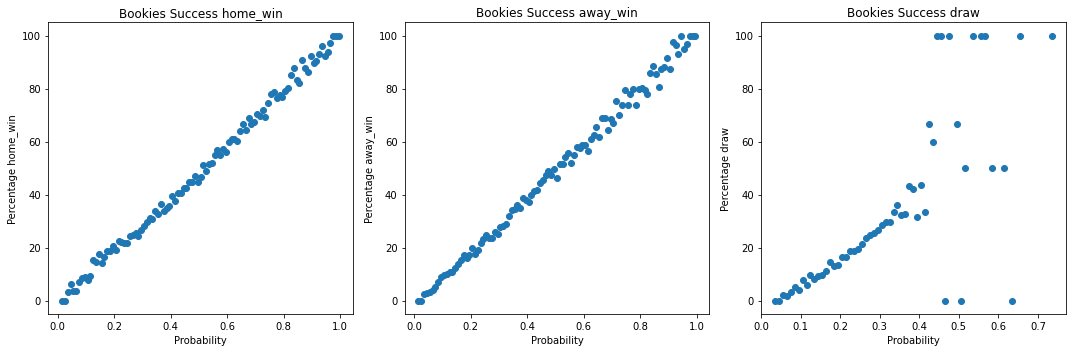

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# home win
df['home_win'] = (df['Home Score'] > df['Away Score']).astype(int)

results_ip = 1/df['Home Team Full Time Odds'] + 1/df['Away Team Full Time Odds'] + 1/df['Draw Full Time Odds']
filtered_results_ip = results_ip[(results_ip >= 1.0) & (results_ip <= 1.15)]

target = 'home_win'
prob = 'home_win_prob'

filtered_results = results_ip[(results_ip >= 1.0) & (results_ip <= 1.15)]
filtered_indices = filtered_results.index

filtered_df = df.loc[filtered_indices]
filtered_df[prob] = 1/filtered_df['Home Team Full Time Odds']

buckets = np.linspace(0, 1, 101)

filtered_df['Bucket'] = pd.cut(filtered_df[prob], bins=buckets, include_lowest=True)
freq = filtered_df.groupby('Bucket')[target].sum() / filtered_df.groupby('Bucket')[target].count() * 100

midpoints = (buckets[:-1] + buckets[1:]) / 2
axes[0].scatter(midpoints, freq)
axes[0].set_xlabel('Probability')
axes[0].set_ylabel(f'Percentage {target}')
axes[0].set_title(f'Bookies Success {target}')

# away win
df['away_win'] = (df['Home Score'] < df['Away Score']).astype(int)

results_ip = 1/df['Home Team Full Time Odds'] + 1/df['Away Team Full Time Odds'] + 1/df['Draw Full Time Odds']
filtered_results_ip = results_ip[(results_ip >= 1.0) & (results_ip <= 1.15)]

target = 'away_win'
prob = 'draw_win_prob'

filtered_results = results_ip[(results_ip >= 1.0) & (results_ip <= 1.15)]
filtered_indices = filtered_results.index

filtered_df = df.loc[filtered_indices]
filtered_df[prob] = 1/filtered_df['Away Team Full Time Odds']

buckets = np.linspace(0, 1, 101)

filtered_df['Bucket'] = pd.cut(filtered_df[prob], bins=buckets, include_lowest=True)
freq = filtered_df.groupby('Bucket')[target].sum() / filtered_df.groupby('Bucket')[target].count() * 100

midpoints = (buckets[:-1] + buckets[1:]) / 2
axes[1].scatter(midpoints, freq)
axes[1].set_xlabel('Probability')
axes[1].set_ylabel(f'Percentage {target}')
axes[1].set_title(f'Bookies Success {target}')

# draw
df['draw'] = (df['Home Score'] == df['Away Score']).astype(int)

results_ip = 1/df['Home Team Full Time Odds'] + 1/df['Away Team Full Time Odds'] + 1/df['Draw Full Time Odds']
filtered_results_ip = results_ip[(results_ip >= 1.0) & (results_ip <= 1.15)]

target = 'draw'
prob = 'draw_prob'

filtered_results = results_ip[(results_ip >= 1.0) & (results_ip <= 1.15)]
filtered_indices = filtered_results.index

filtered_df = df.loc[filtered_indices]
filtered_df[prob] = 1/filtered_df['Draw Full Time Odds']

buckets = np.linspace(0, 1, 101)

filtered_df['Bucket'] = pd.cut(filtered_df[prob], bins=buckets, include_lowest=True)
freq = filtered_df.groupby('Bucket')[target].sum() / filtered_df.groupby('Bucket')[target].count() * 100

midpoints = (buckets[:-1] + buckets[1:]) / 2
axes[2].scatter(midpoints, freq)
axes[2].set_xlabel('Probability')
axes[2].set_ylabel(f'Percentage {target}')
axes[2].set_title(f'Bookies Success {target}')

plt.tight_layout()
plt.show()

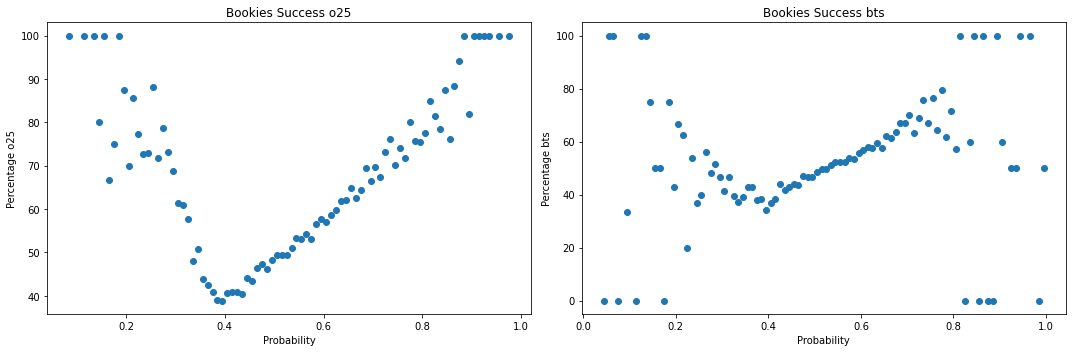

In [20]:
df['o25'] = (df['Home Score'] + df['Away Score'] > 2).astype(int)
df['bts'] = ((df['Home Score'] > 0) & (df['Away Score'] > 0)).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Over 2.5
filtered_o25_ip = o25_ip[(o25_ip > 1) | (o25_ip < 1.1)]

target = 'o25'
prob = 'o25_prob'

filtered_results = results_ip[(results_ip >= 1.0) & (results_ip <= 1.15)]
filtered_indices = filtered_results.index

filtered_df = df.loc[filtered_indices]
filtered_df[prob] = 1/filtered_df['Over 2.5 Full Time Odds']

buckets = np.linspace(0, 1, 101)

filtered_df['Bucket'] = pd.cut(filtered_df[prob], bins=buckets, include_lowest=True)
freq = filtered_df.groupby('Bucket')[target].sum() / filtered_df.groupby('Bucket')[target].count() * 100

midpoints = (buckets[:-1] + buckets[1:]) / 2
axes[0].scatter(midpoints, freq)
axes[0].set_xlabel('Probability')
axes[0].set_ylabel(f'Percentage {target}')
axes[0].set_title(f'Bookies Success {target}')

# Both Teams to Score (BTTS)
btts_ip = 1/df['BTS Yes Full Time Odds'] + 1/df['BTS No Full Time Odds']
filtered_btts_ip = btts_ip[(btts_ip >= 1.0) & (btts_ip <= 1.15)]

target = 'bts'
prob = 'bts_prob'

filtered_results = results_ip[(results_ip >= 1.0) & (results_ip <= 1.15)]
filtered_indices = filtered_results.index

filtered_df = df.loc[filtered_indices]
filtered_df[prob] = 1/filtered_df['BTS Yes Full Time Odds']

buckets = np.linspace(0, 1, 101)

filtered_df['Bucket'] = pd.cut(filtered_df[prob], bins=buckets, include_lowest=True)
freq = filtered_df.groupby('Bucket')[target].sum() / filtered_df.groupby('Bucket')[target].count() * 100

midpoints = (buckets[:-1] + buckets[1:]) / 2
axes[1].scatter(midpoints, freq)
axes[1].set_xlabel('Probability')
axes[1].set_ylabel(f'Percentage {target}')
axes[1].set_title(f'Bookies Success {target}')

plt.tight_layout()
plt.show()


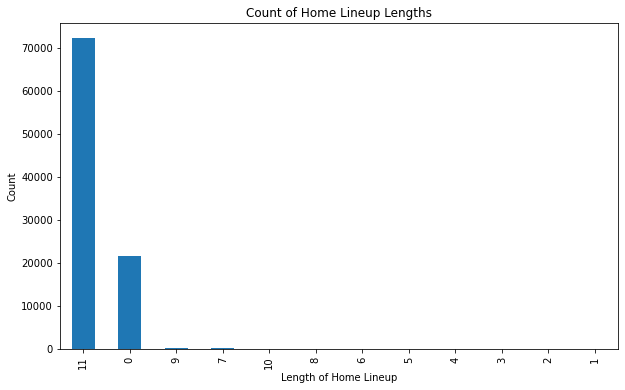

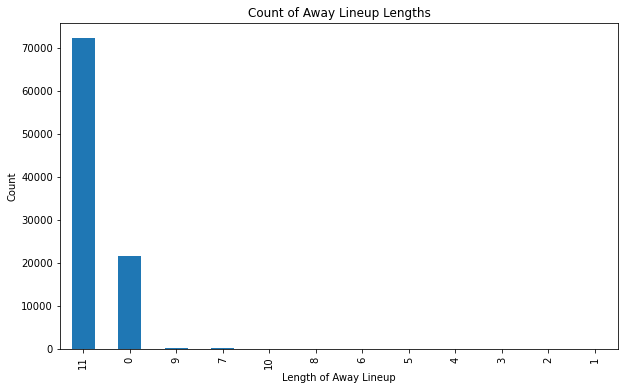

In [21]:
home_lineup = df['Home Lineup'].dropna().apply(lambda x: ast.literal_eval(x))
length_counts = home_lineup.apply(len).value_counts()

plt.figure(figsize=(10, 6))
length_counts.plot(kind='bar')
plt.xlabel('Length of Home Lineup')
plt.ylabel('Count')
plt.title('Count of Home Lineup Lengths')
plt.show()

away_lineup = df['Away Lineup'].dropna().apply(lambda x: ast.literal_eval(x))
length_counts = away_lineup.apply(len).value_counts()

plt.figure(figsize=(10, 6))
length_counts.plot(kind='bar')
plt.xlabel('Length of Away Lineup')
plt.ylabel('Count')
plt.title('Count of Away Lineup Lengths')
plt.show()

The 20k empty values is in addition to roughly 6k nan values for each column. This is potentially a very useful datapoint, but it is not usable currently due to the high number of missing values.


In [22]:
# player names

unique_players1 = [name for lineup in home_lineup for name in lineup]
unique_players2 = [name for lineup in away_lineup for name in lineup]
unique_players = set(unique_players1 + unique_players2)
total_unique_players = len(unique_players)
print(f"Total unique players: {total_unique_players}")

Total unique players: 45368


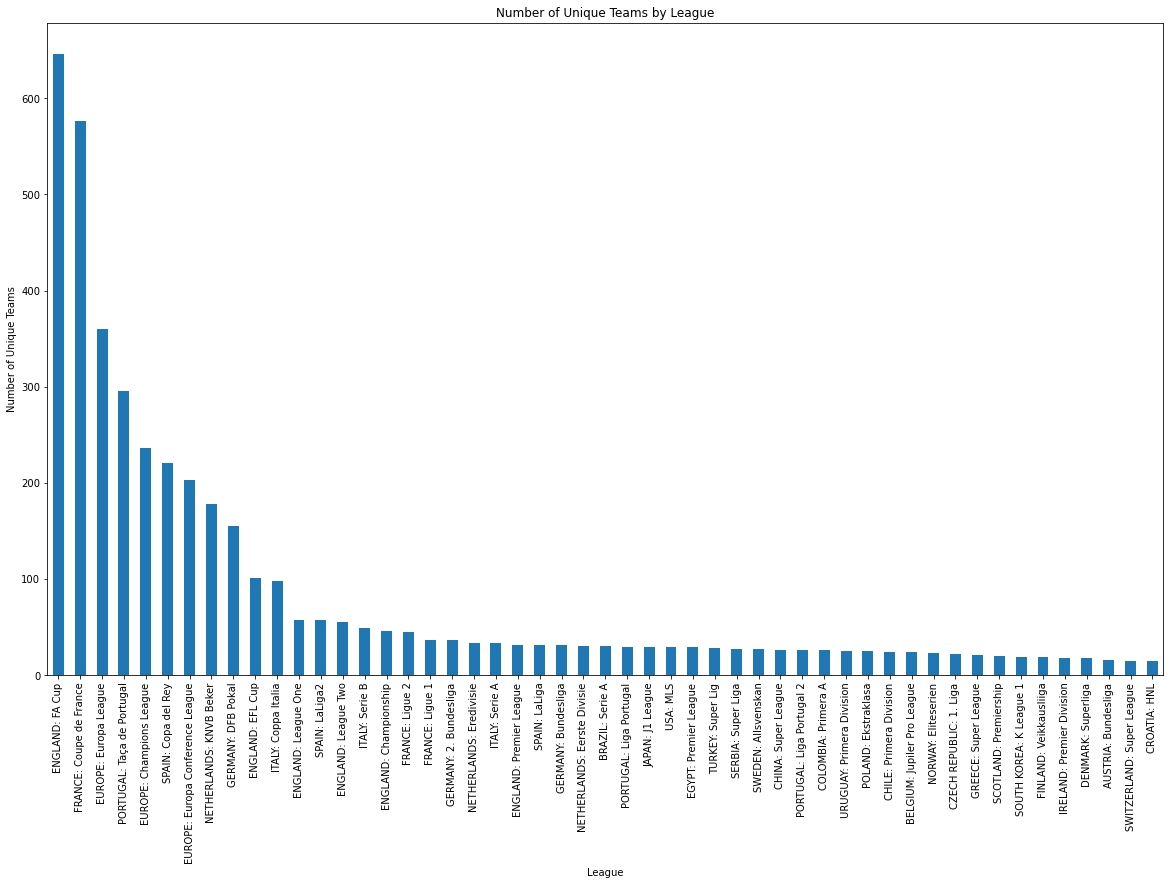

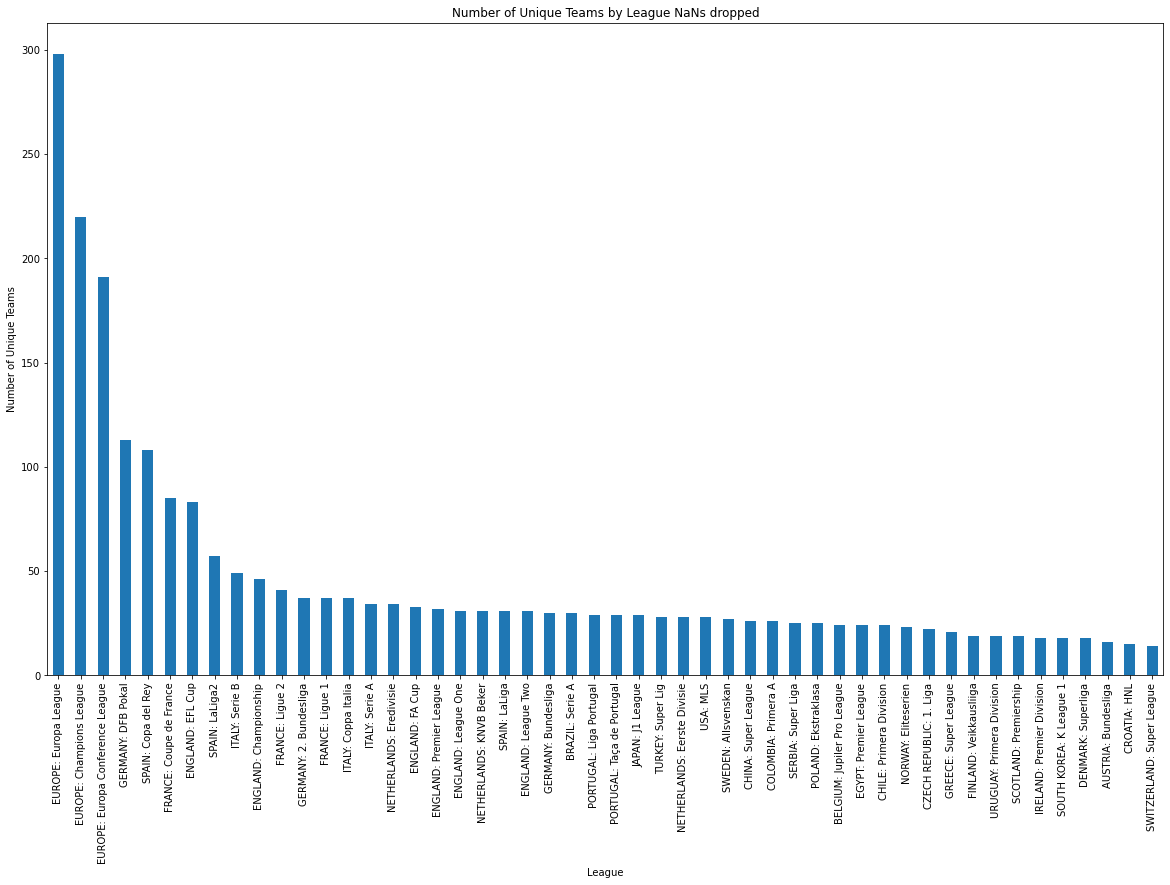

In [23]:
unique_teams_by_league = df.groupby('League')['Home Team'].nunique()
unique_teams_by_league = unique_teams_by_league.sort_values(ascending=False) 

plt.figure(figsize=(20, 12))
unique_teams_by_league.plot(kind='bar')

plt.xlabel('League')
plt.ylabel('Number of Unique Teams')
plt.title('Number of Unique Teams by League')
plt.show()

df1 = df.dropna()
unique_teams_by_league = df1.groupby('League')['Home Team'].nunique()
unique_teams_by_league = unique_teams_by_league.sort_values(ascending=False) 

plt.figure(figsize=(20, 12))
unique_teams_by_league.plot(kind='bar')

plt.xlabel('League')
plt.ylabel('Number of Unique Teams')
plt.title('Number of Unique Teams by League NaNs dropped')
plt.show()


The data exploration we have done has uncovered missing data and inconsistencies in our data. Now we will process and clean our data. But there is still more to do. For now, the only data we have that might be useful in a predictive model is the odds data. All other features are either useless to this purpose or contain information about the various outcomes of the match.

**Data Processing**

In [24]:
for col in df.columns:
    if "Possession" in col:
        df[col] = df[col].apply(lambda x: pd.to_numeric(x.rstrip('%')) / 100 if isinstance(x, str) else x)
        
df['Home Team'] = df['Home Team'].astype(str).str.split(' \(').str[0]
df['Away Team'] = df['Away Team'].astype(str).str.split(' \(').str[0]

In [25]:
dropped = []
for col in df.columns:
    nan_sum = df[col].isnull().sum()
    if nan_sum <= 21000:
        continue
    else:
        dropped.append(col)
df.drop(dropped, axis = 1, inplace = True)
df

,Match ID,Home Team,Away Team,Country,League,Kick Off,Home 1st Half Goals,Away 1st Half Goals,Home 2nd Half Goals,Away 2nd Half Goals,...,Either DNB Full Time Odds,Away DNB Team Full Time Odds,BTS Yes Full Time Odds,BTS No Full Time Odds,ts,home_win,away_win,draw,o25,bts
35401,g_1_8YTbqtc7,Shirak Gyumri,Tre Penne,EUROPE,EUROPE: Champions League,2013-07-02 14:00:00,1.0,0.0,2.0,0.0,...,14.500000,14.500000,2.950000,1.360000,1.372774e+12,1,0,0,1,0
37193,g_1_vcrck9iH,Met. Skopje,Qarabag,EUROPE,EUROPE: Europa League,2013-07-02 16:45:00,0.0,0.0,0.0,1.0,...,1.273333,1.270000,1.855000,1.837500,1.372784e+12,0,1,0,0,0
37253,g_1_6V4GxW7B,Sliema,Khazar Lenkoran,EUROPE,EUROPE: Europa League,2013-07-02 16:45:00,0.0,1.0,1.0,0.0,...,2.373333,2.120000,2.012500,1.710000,1.372784e+12,0,0,1,0,1
37416,g_1_A3B7vhwa,Narva,Gefle,EUROPE,EUROPE: Europa League,2013-07-02 17:00:00,0.0,1.0,0.0,2.0,...,4.016667,2.876667,2.020000,1.723333,1.372784e+12,0,1,0,1,0
35375,g_1_nPS2r0CD,Lusitanos,Streymur,EUROPE,EUROPE: Champions League,2013-07-02 18:30:00,2.0,0.0,0.0,2.0,...,1.500000,1.643333,1.770000,1.926667,1.372790e+12,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7249,g_1_WzTCFYOk,Guangzhou City,Cangzhou,CHINA,CHINA: Super League,2022-12-31 07:00:00,0.0,4.0,1.0,0.0,...,1.074000,1.540000,1.586667,2.265000,1.672470e+12,0,1,0,1,1
7310,g_1_jwqEDCg2,Shanghai Port,Changchun Yatai,CHINA,CHINA: Super League,2022-12-31 07:00:00,4.0,0.0,0.0,0.0,...,6.604000,2.810000,2.052000,1.704000,1.672470e+12,1,0,0,1,0
7544,g_1_CnpAEhvd,Zhejiang Professional,Wuhan FC,CHINA,CHINA: Super League,2022-12-31 07:00:00,3.0,0.0,1.0,0.0,...,10.000000,7.250000,2.912000,1.376000,1.672470e+12,1,0,0,1,0
7356,g_1_08Q4zz1F,Wuhan Three Towns,Tianjin Jinmen Tiger,CHINA,CHINA: Super League,2022-12-31 07:00:00,3.0,0.0,3.0,0.0,...,1.230000,2.100000,1.520000,2.360000,1.672470e+12,1,0,0,1,0


We are ready to impute missing values. We do this by using a 5 period ema. There are still negative values and mismatched values to deal with, but we will have a better idea as to how to deal with them once we deal with the missing values. We will impute until our desired columns have a missing value rate of less than 5%.

In [26]:
def impute_nans(df, columns, venue):
    
    new_data = []
    
    grouped = df.groupby(f'{venue} Team')
    
    for team, subset in grouped:
        subset_data = subset[columns].values
        mask = ((np.isnan(subset_data)) | (subset_data < 0) 
                | (subset_data == np.inf) | (subset_data == -np.inf)) 
        subset_data = np.where(mask, np.roll(subset_data, 1, axis=0), subset_data)
        subset_data = np.where(mask, np.round(pd.DataFrame(subset_data).rolling(window=5, min_periods=1).mean().values, 
                                              decimals=0), subset_data)
        subset[columns] = subset_data
        new_data.append(subset)
    new_df = pd.concat(new_data)
    new_df.drop_duplicates(inplace=True)
    new_df.sort_values(by="ts", ascending=True, inplace=True)
    return new_df

numeric_cols = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]  

imputed_columns = []
for column in numeric_cols:
    if "Odds" in column:
        continue
    else:
        imputed_columns.append(column)
        
df = impute_nans(df, imputed_columns, 'Home')
df = impute_nans(df, imputed_columns, 'Away')

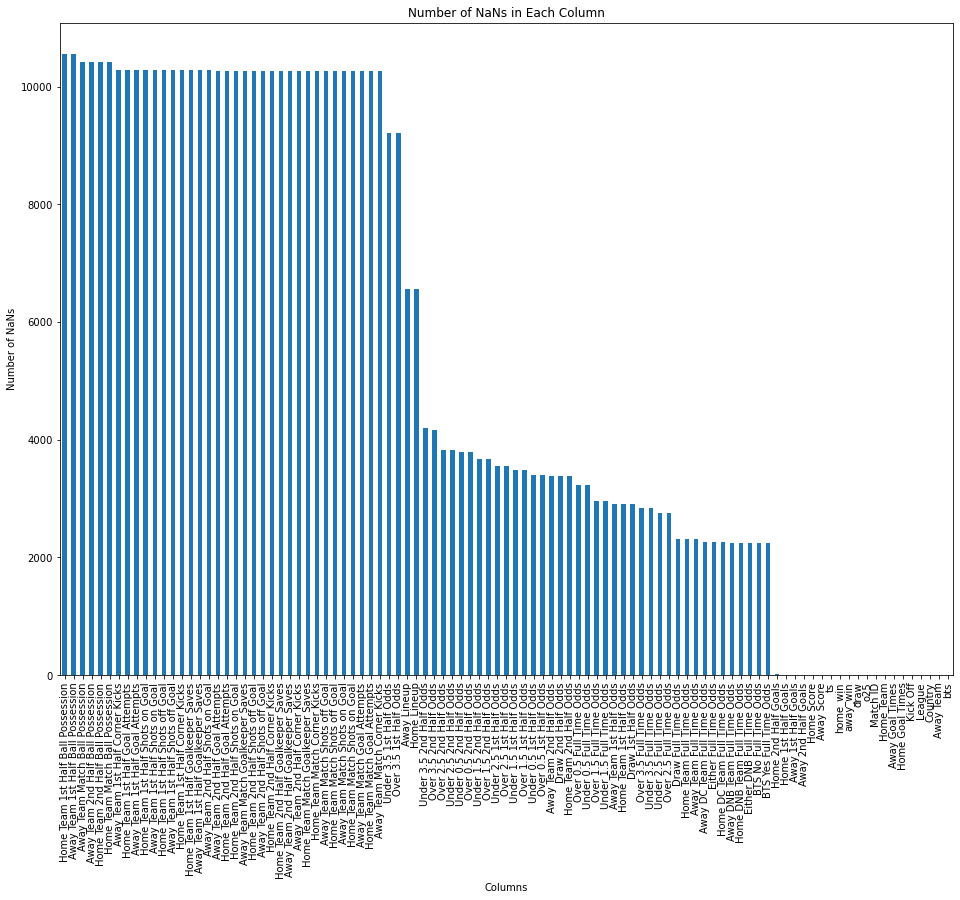

In [27]:
nan_counts = df.isnull().sum()
nan_counts = nan_counts.sort_values(ascending=False)  # Sort in descending order

nan_counts.plot(kind='bar', figsize=(16, 12))
plt.xlabel('Columns')
plt.ylabel('Number of NaNs')
plt.title('Number of NaNs in Each Column')
plt.show()

In [28]:
negs = []
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        neg_sum = df[col].lt(0).sum()  
        if neg_sum > 0:
            print(f"Column: {col}, Sum of Negative Values: {neg_sum}")
    
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        neg_indices = df.index[df[col] < 0]
        neg_count = len(neg_indices)
        if neg_count > 0:
            print(f"Column: {col}")
            print(f"Number of negative values: {neg_count}")
            print(f"Indices with negative values: {neg_indices}")
            print("------------------------------")

Column: Home Team 2nd Half Goal Attempts, Sum of Negative Values: 9
Column: Home Team 2nd Half Shots on Goal, Sum of Negative Values: 9
Column: Away Team 2nd Half Shots on Goal, Sum of Negative Values: 5
Column: Home Team 2nd Half Goal Attempts
Number of negative values: 9
Indices with negative values: Index([25489, 25365, 25128, 25314, 25229, 25255, 25462, 24973, 25113], dtype='int64')
------------------------------
Column: Home Team 2nd Half Shots on Goal
Number of negative values: 9
Indices with negative values: Index([25489, 25365, 25128, 25314, 25229, 25255, 25462, 24973, 25113], dtype='int64')
------------------------------
Column: Away Team 2nd Half Shots on Goal
Number of negative values: 5
Indices with negative values: Index([24985, 25285, 25225, 24991, 25162], dtype='int64')
------------------------------


Having examined these coumns at the indices above it appears as though mistakes are being made in the reporting of inplay statistics which is then being corrected by using negative values so that the final tally for the match total is correct. Here is an example:

In [29]:
df_eg = df[['Home Team 1st Half Goal Attempts', 'Home Team 2nd Half Goal Attempts', 'Home Team Match Goal Attempts']]
df_eg.loc[25489]

Home Team 1st Half Goal Attempts    2.0
Home Team 2nd Half Goal Attempts   -1.0
Home Team Match Goal Attempts       1.0
Name: 25489, dtype: float64

In [30]:
# repeat imputation
df = impute_nans(df, imputed_columns, 'Home')
df = impute_nans(df, imputed_columns, 'Away')

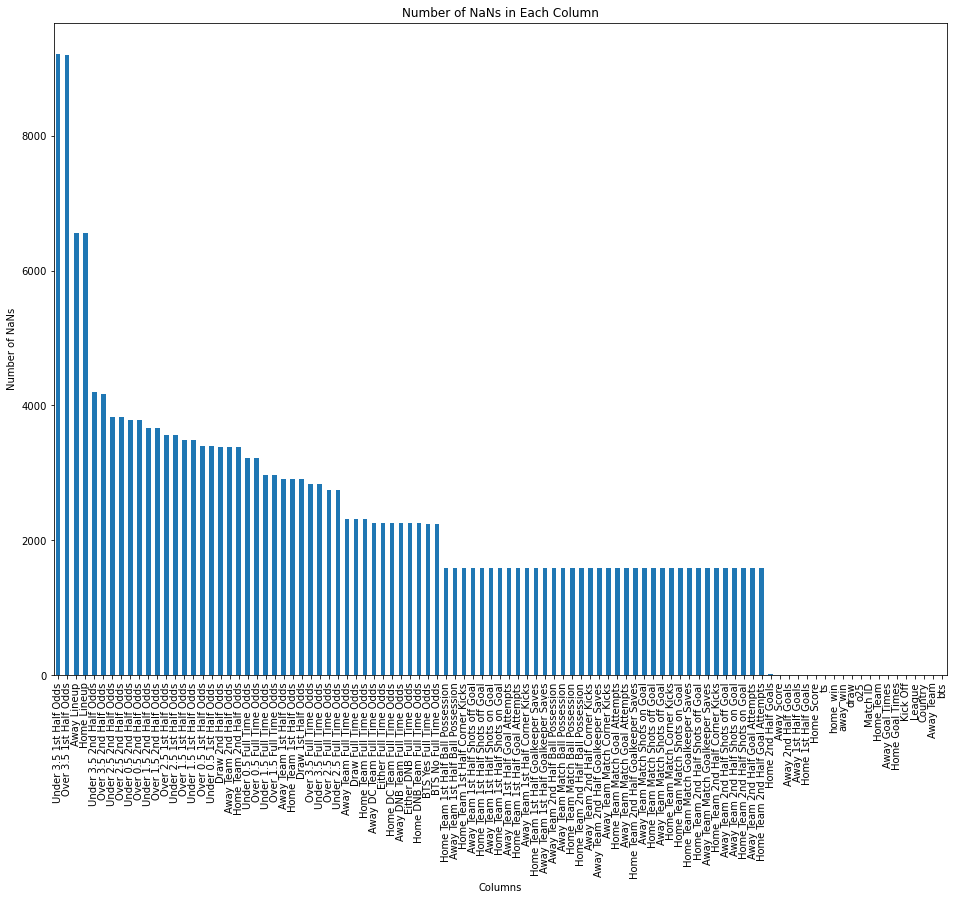

In [31]:
nan_counts = df.isnull().sum()
nan_counts = nan_counts.sort_values(ascending=False)  

nan_counts.plot(kind='bar', figsize=(16, 12))
plt.xlabel('Columns')
plt.ylabel('Number of NaNs')
plt.title('Number of NaNs in Each Column')
plt.show()

In [32]:
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        if "Odds" in col or "Goals" in col or "Poss" in col:
            continue
        if "1st Half" in col:
            col_p = col.replace("1st Half", "")
            col_2 = col.replace("1st", "2nd")
            col_m = col.replace("1st Half", "Match")
            mismatches = len(df[(df[col] + df[col_2] != df[col_m])])
            print(f"Total number of mismatches for {col_p}: {mismatches}")

for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        if "1st Half Poss" in col:
            col_p = col.replace("1st Half", "")
            col_2 = col.replace("1st", "2nd")
            col_m = col.replace("1st Half", "Match")
            mismatches = len((df[(df[col] + df[col_2])/2 != df[col_m]]))
            print(f"Total number of mismatches for {col_p}: {mismatches}")
                
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        if "1st Half Goals" in col:
            col_p = col.replace("1st Half Goals", "Score")
            col_2 = col.replace("1st", "2nd")
            col_m = col.replace("1st Half Goals", "Score")
            mismatches = len((df[df[col] + df[col_2] != df[col_m]]))
            print(f"Total number of mismatches for {col_p}: {mismatches}")

Total number of mismatches for Home Team  Goal Attempts: 6147
Total number of mismatches for Away Team  Goal Attempts: 6152
Total number of mismatches for Home Team  Shots on Goal: 5601
Total number of mismatches for Away Team  Shots on Goal: 5930
Total number of mismatches for Home Team  Shots off Goal: 5754
Total number of mismatches for Away Team  Shots off Goal: 5777
Total number of mismatches for Home Team  Corner Kicks: 5511
Total number of mismatches for Away Team  Corner Kicks: 5875
Total number of mismatches for Home Team  Goalkeeper Saves: 5548
Total number of mismatches for Away Team  Goalkeeper Saves: 5465
Total number of mismatches for Home Score: 2318
Total number of mismatches for Away Score: 2299


There are still a large number of mismatches. It may be that the inplay stats are more often unreliable than the final match tallies, as we have checked the final match statistics across a variety of leagues against other soccer statistics websites. 

In [33]:
df['home_win'] = ((df['Home Score'] > df['Away Score'])).astype(int)
df['draw'] = ((df['Home Score'] == df['Away Score'])).astype(int)
df['away_win'] = ((df['Away Score'] > df['Home Score'])).astype(int)
df['o15'] = ((df['Home Score'] + df['Away Score'] > 1)).astype(int)
df['o25'] = ((df['Home Score'] + df['Away Score'] > 2)).astype(int)
df['home_goal'] = ((df['Home Score'] > 0)).astype(int)
df['away_goal'] = ((df['Away Score'] > 0)).astype(int)
df['bts'] = (((df['Home Score'] > 0) & (df['Away Score'] > 0))).astype(int)
df['home_dc'] = (((df['home_win'] > 0) | (df['draw'] > 0))).astype(int)
df['either_dc'] = (((df['home_win'] > 0) | (df['away_win'] > 0))).astype(int)
df['away_dc'] = (((df['draw'] > 0) | (df['away_win'] > 0))).astype(int)

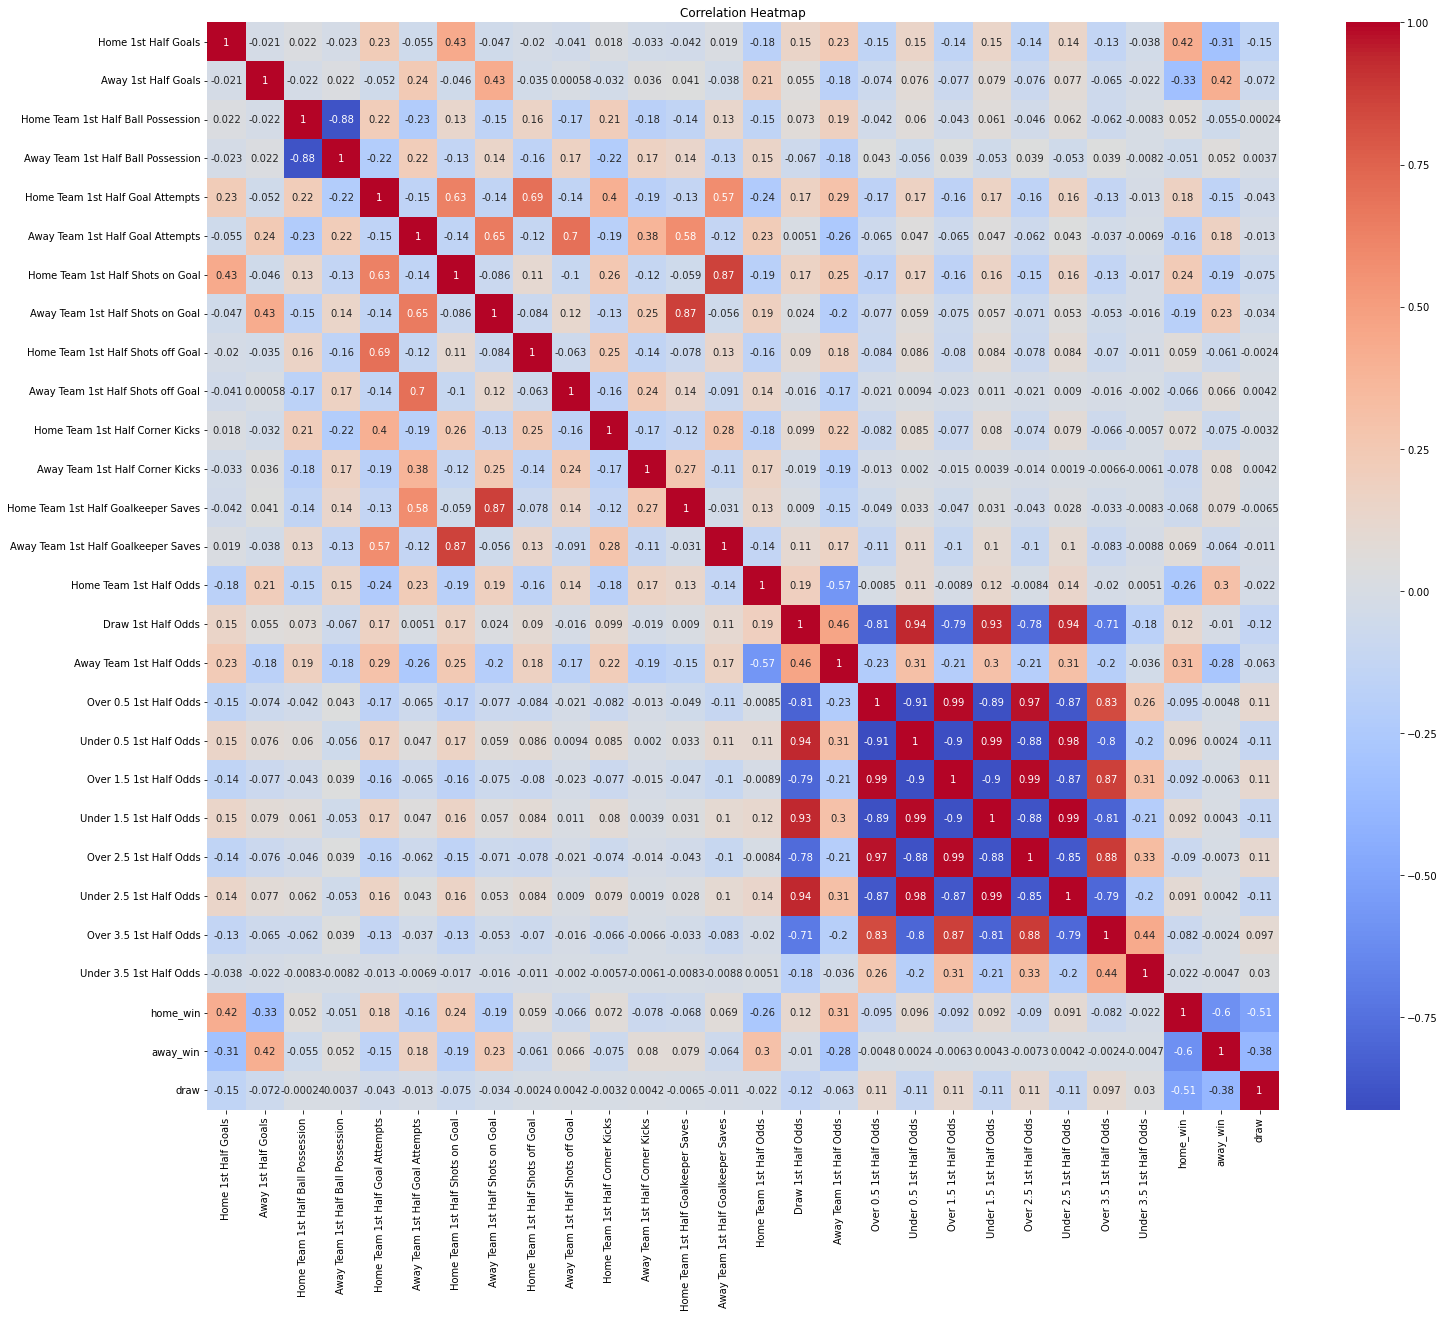

In [34]:
first_half_cols = [col for col in numeric_cols if "1st Half" in col]
first_half_cols.append('home_win')
first_half_cols.append('away_win')
first_half_cols.append('draw')
corr = df[first_half_cols].corr()

plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

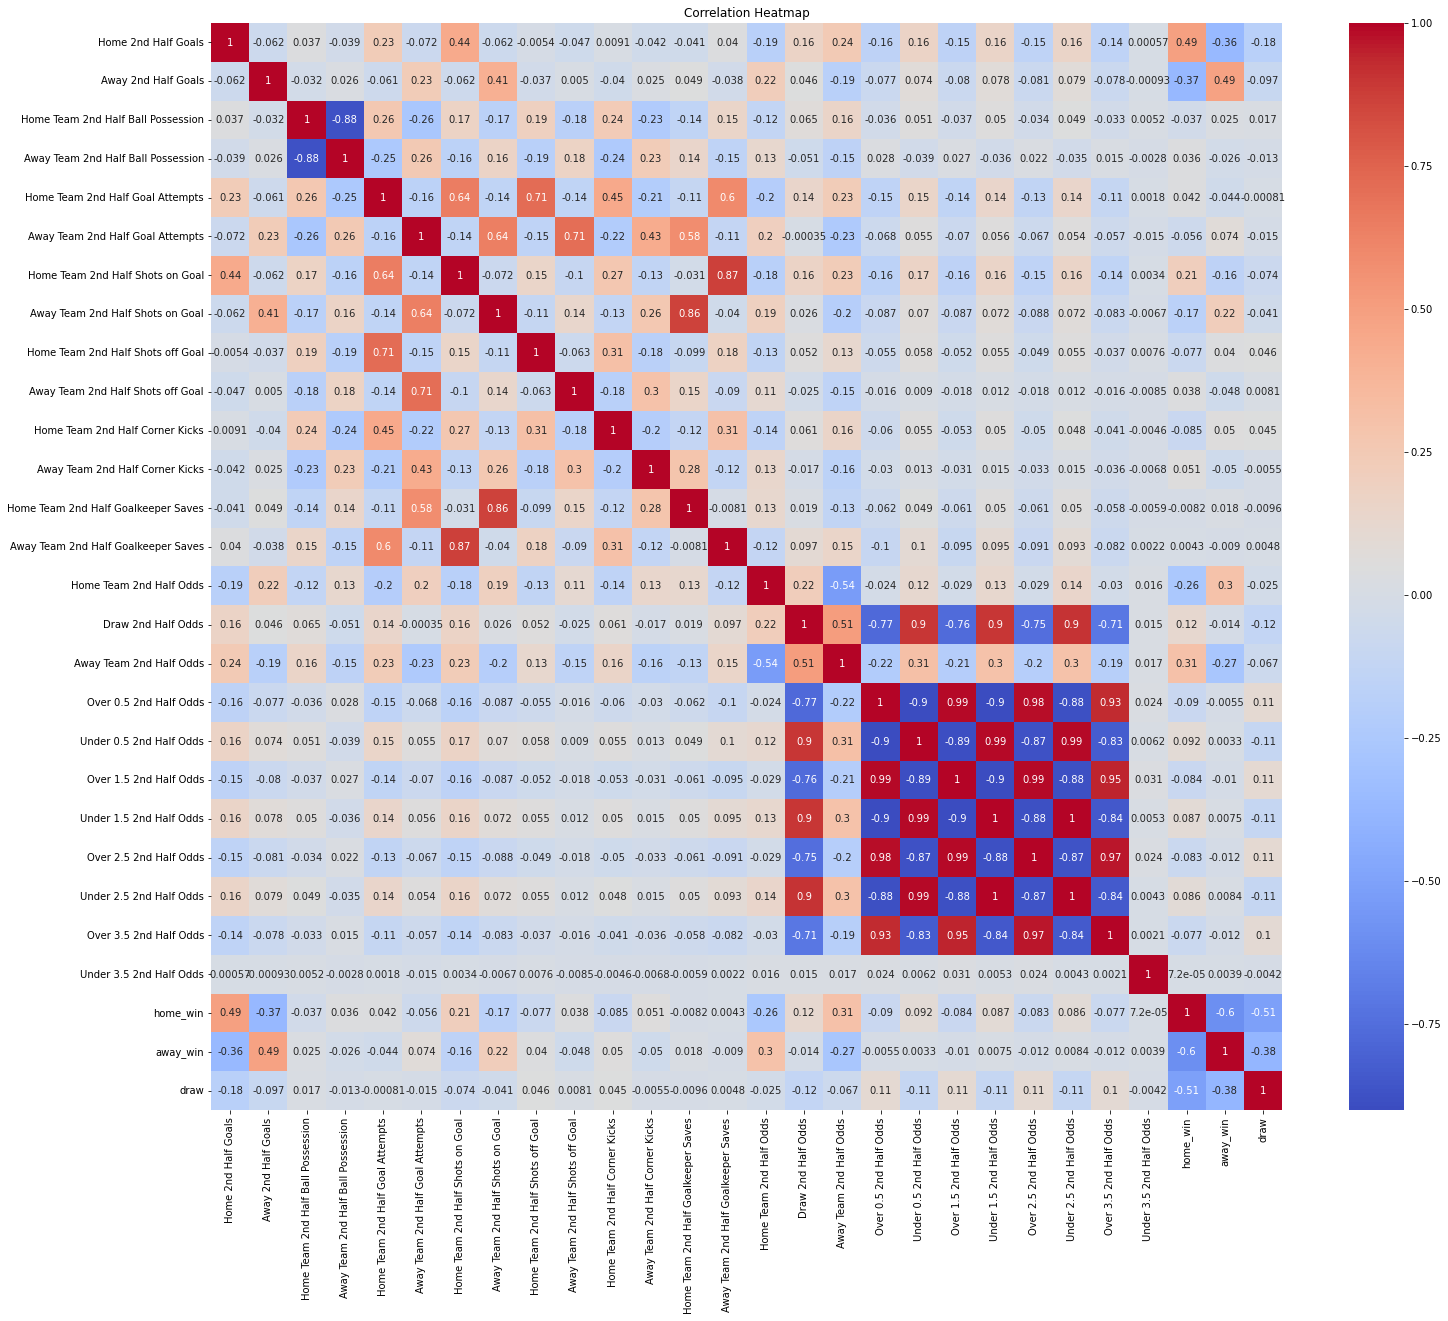

In [35]:
first_half_cols = [col for col in numeric_cols if "2nd Half" in col]
first_half_cols.append('home_win')
first_half_cols.append('away_win')
first_half_cols.append('draw')
corr = df[first_half_cols].corr()

plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

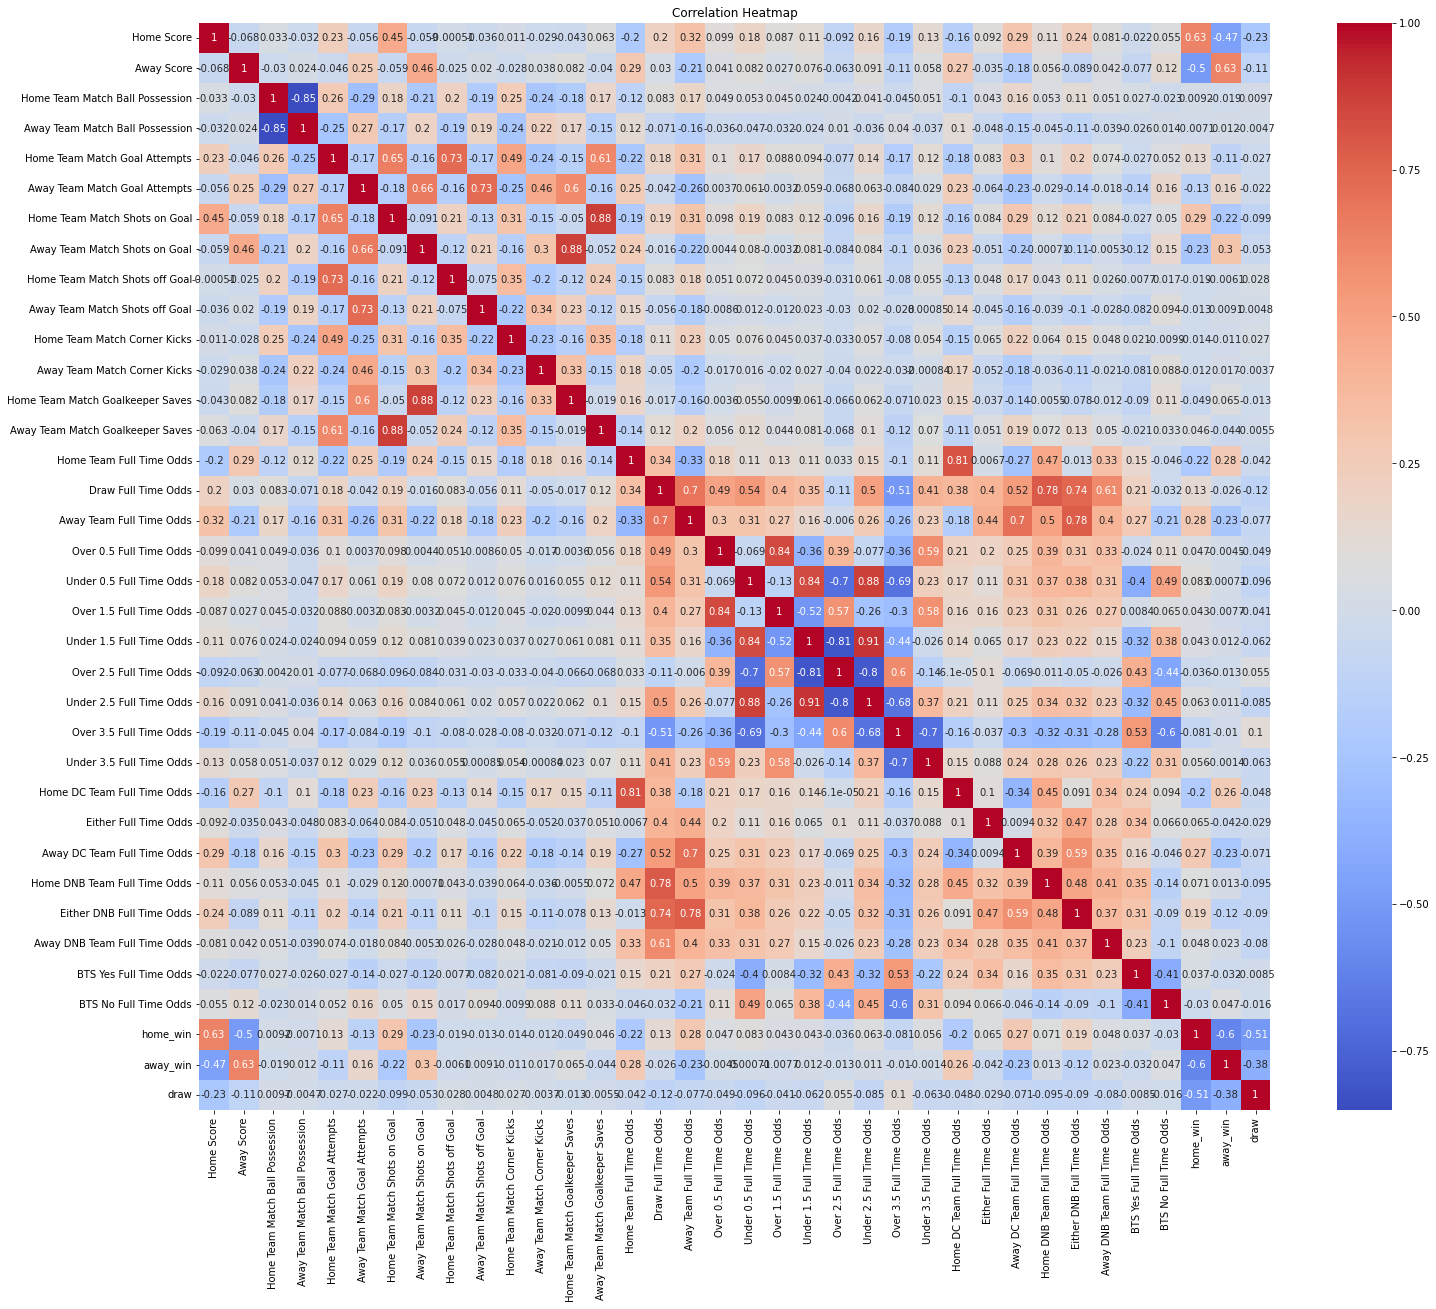

In [36]:
first_half_cols = [col for col in numeric_cols if "Match" in col or "Full Time" in col or "Score" in col]
first_half_cols.append('home_win')
first_half_cols.append('away_win')
first_half_cols.append('draw')
corr = df[first_half_cols].corr()

plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The inplay statistics show a weaker correlation with the target variable 'home_win'. In addition to this they are strongly correlated with their corresponding full time values. Other problematic variables like possession, some of the odds variables, and others show little to no correlation. It appears that the most useful features will be engineered from the score and shots statistics.

In [37]:
dropped = []
for column in df.columns:
    if "1st Half" in column or "2nd Half" in column or "Possession" in column:
        if not "Goals" in column:
            dropped.append(column)
        
df.drop(dropped, axis = 1, inplace = True)
df.columns

Index(['Match ID', 'Home Team', 'Away Team', 'Country', 'League', 'Kick Off',
       'Home 1st Half Goals', 'Away 1st Half Goals', 'Home 2nd Half Goals',
       'Away 2nd Half Goals', 'Home Lineup', 'Away Lineup', 'Home Score',
       'Away Score', 'Home Goal Times', 'Away Goal Times',
       'Home Team Match Goal Attempts', 'Away Team Match Goal Attempts',
       'Home Team Match Shots on Goal', 'Away Team Match Shots on Goal',
       'Home Team Match Shots off Goal', 'Away Team Match Shots off Goal',
       'Home Team Match Corner Kicks', 'Away Team Match Corner Kicks',
       'Home Team Match Goalkeeper Saves', 'Away Team Match Goalkeeper Saves',
       'Home Team Full Time Odds', 'Draw Full Time Odds',
       'Away Team Full Time Odds', 'Over 0.5 Full Time Odds',
       'Under 0.5 Full Time Odds', 'Over 1.5 Full Time Odds',
       'Under 1.5 Full Time Odds', 'Over 2.5 Full Time Odds',
       'Under 2.5 Full Time Odds', 'Over 3.5 Full Time Odds',
       'Under 3.5 Full Time Odds', '

We now take a look at outliers. Outliers will affect the feature engineering and model building process. We will deal with outliers via winsorisation---i.e by capping the column at a maximum value. If our data is normally distributed we can find these extreme values using z-scores. Otherwise we will use percentiles.

Column 'Home 1st Half Goals' is not normally distributed (p-value: 0.0000)


C:\Users\kiera\AppData\Roaming\Python\Python39\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


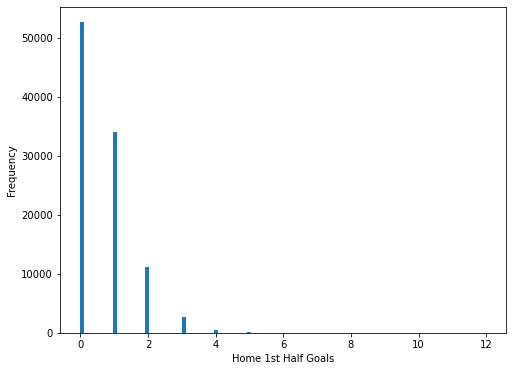

Column 'Away 1st Half Goals' is not normally distributed (p-value: 0.0000)


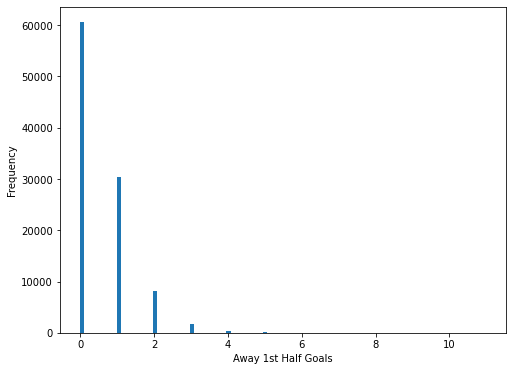

Column 'Home 2nd Half Goals' is not normally distributed (p-value: 0.0000)


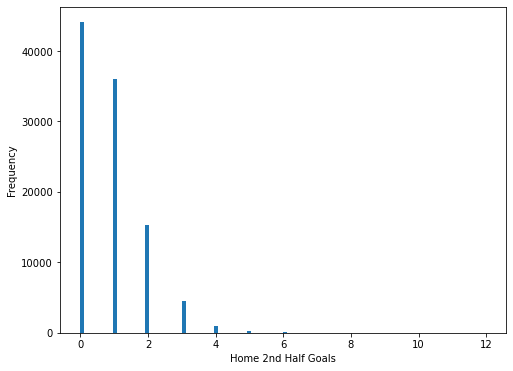

Column 'Away 2nd Half Goals' is not normally distributed (p-value: 0.0000)


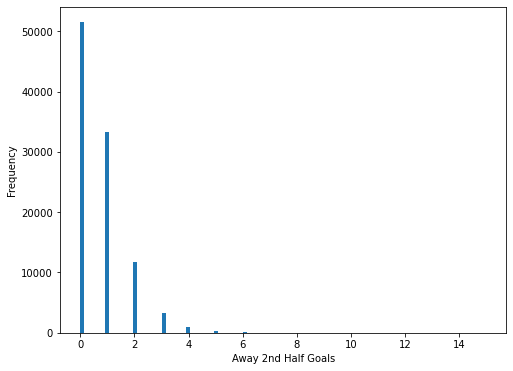

Column 'Home Score' is not normally distributed (p-value: 0.0000)


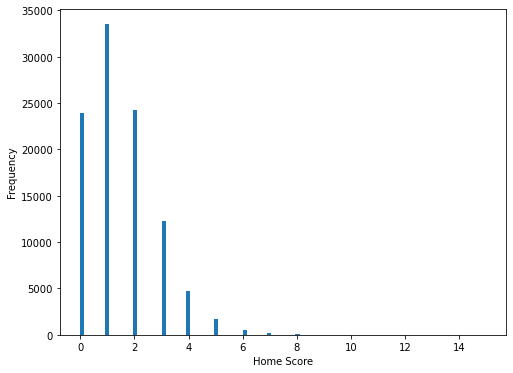

Column 'Away Score' is not normally distributed (p-value: 0.0000)


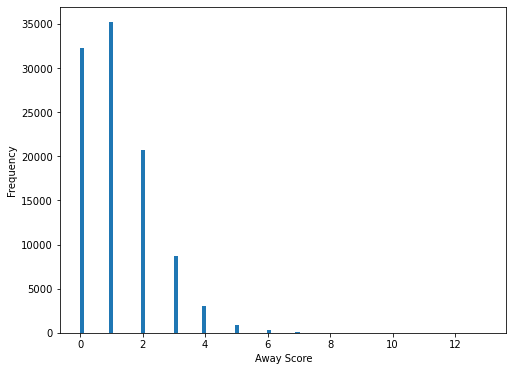

Column 'Home Team Match Goal Attempts' is not normally distributed (p-value: 0.0000)


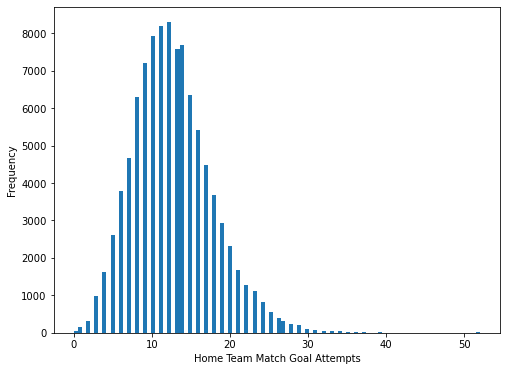

Column 'Away Team Match Goal Attempts' is not normally distributed (p-value: 0.0000)


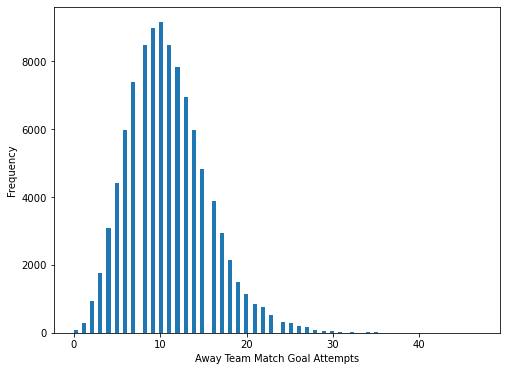

Column 'Home Team Match Shots on Goal' is not normally distributed (p-value: 0.0000)


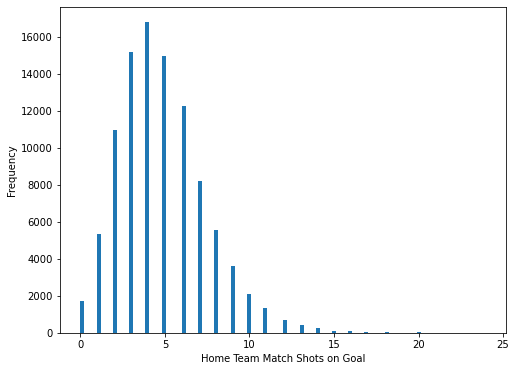

Column 'Away Team Match Shots on Goal' is not normally distributed (p-value: 0.0000)


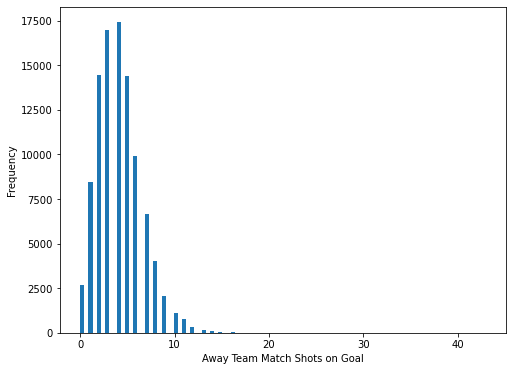

Column 'Home Team Match Shots off Goal' is not normally distributed (p-value: 0.0000)


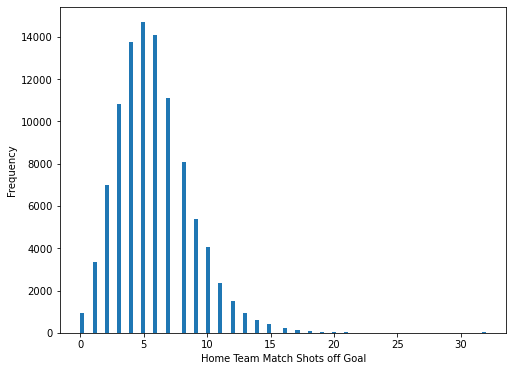

Column 'Away Team Match Shots off Goal' is not normally distributed (p-value: 0.0000)


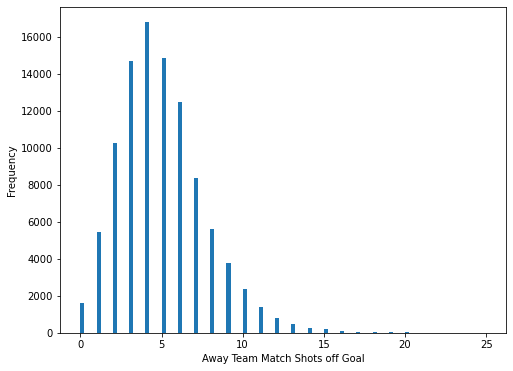

Column 'Home Team Match Corner Kicks' is not normally distributed (p-value: 0.0000)


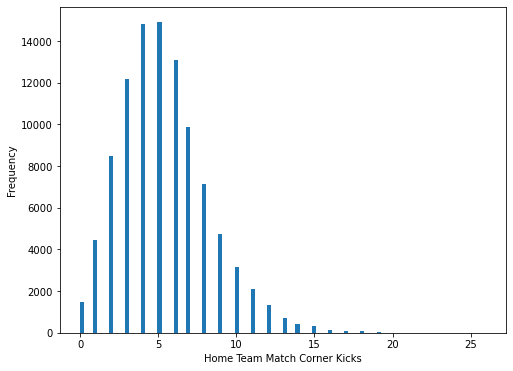

Column 'Away Team Match Corner Kicks' is not normally distributed (p-value: 0.0000)


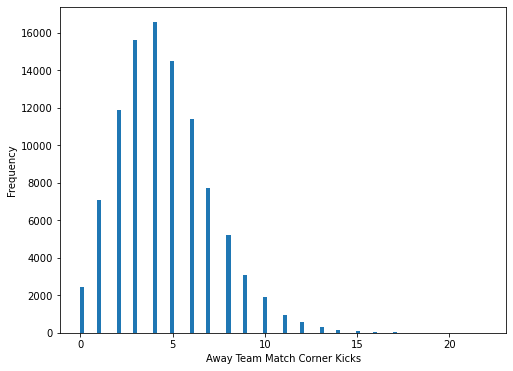

Column 'Home Team Match Goalkeeper Saves' is not normally distributed (p-value: 0.0000)


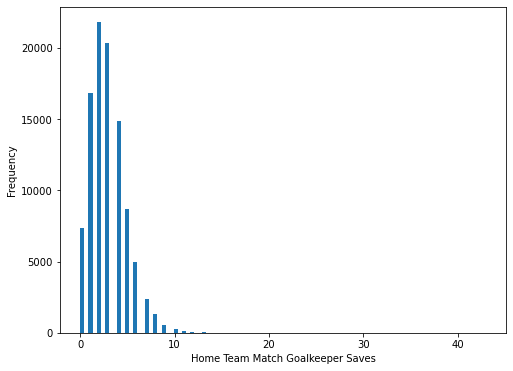

Column 'Away Team Match Goalkeeper Saves' is not normally distributed (p-value: 0.0000)


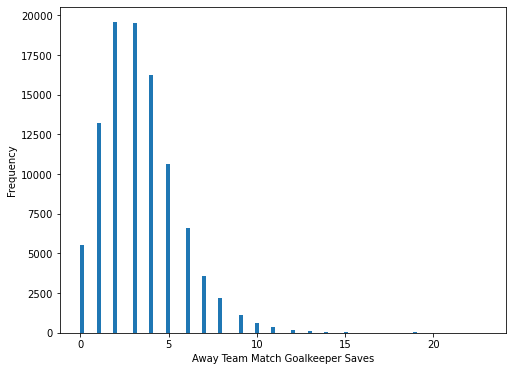

Column 'Home Team Full Time Odds' is not normally distributed (p-value: 0.0000)


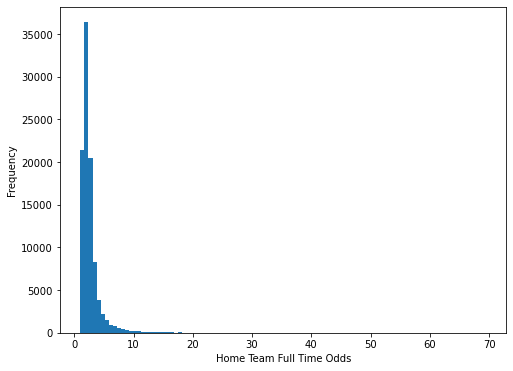

Column 'Draw Full Time Odds' is not normally distributed (p-value: 0.0000)


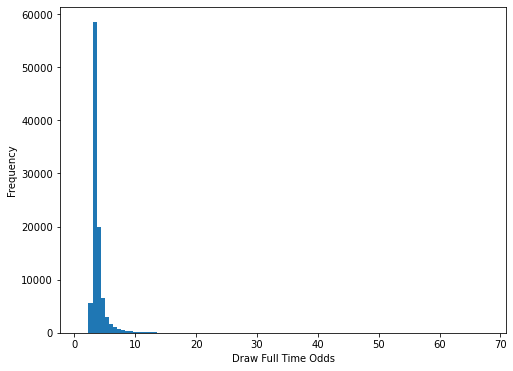

Column 'Away Team Full Time Odds' is not normally distributed (p-value: 0.0000)


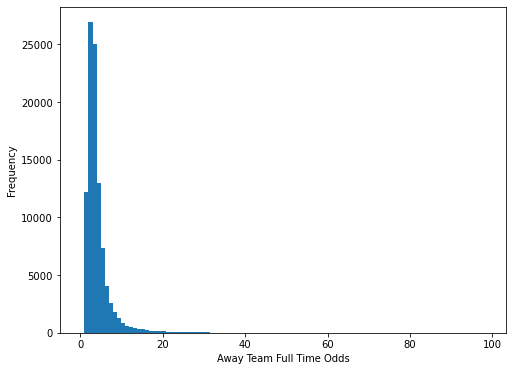

Column 'Over 0.5 Full Time Odds' is not normally distributed (p-value: 0.0000)


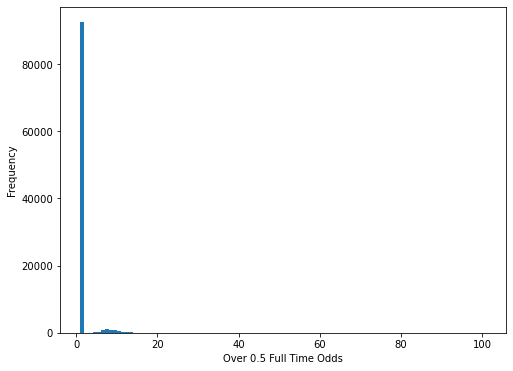

Column 'Under 0.5 Full Time Odds' is not normally distributed (p-value: 0.0000)


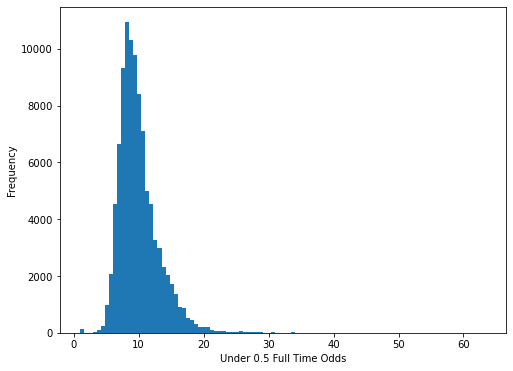

Column 'Over 1.5 Full Time Odds' is not normally distributed (p-value: 0.0000)


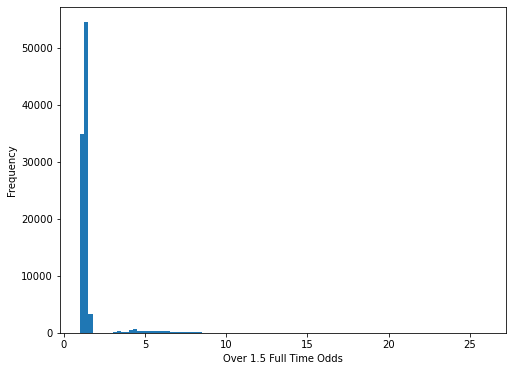

Column 'Under 1.5 Full Time Odds' is not normally distributed (p-value: 0.0000)


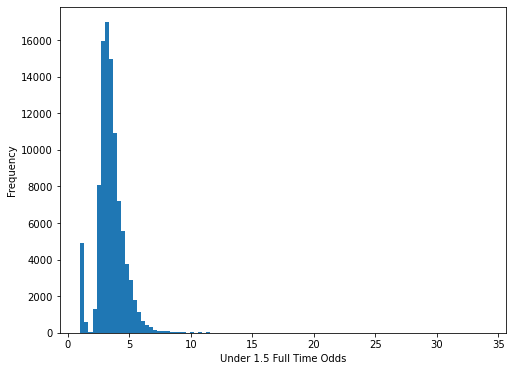

Column 'Over 2.5 Full Time Odds' is not normally distributed (p-value: 0.0000)


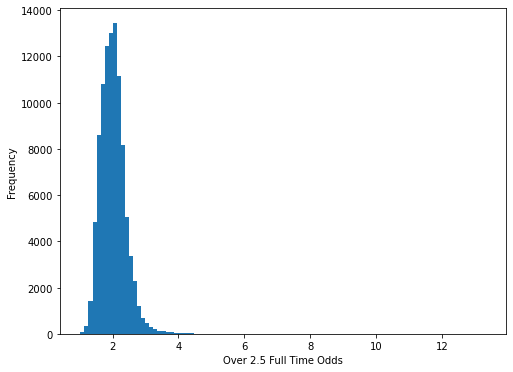

Column 'Under 2.5 Full Time Odds' is not normally distributed (p-value: 0.0000)


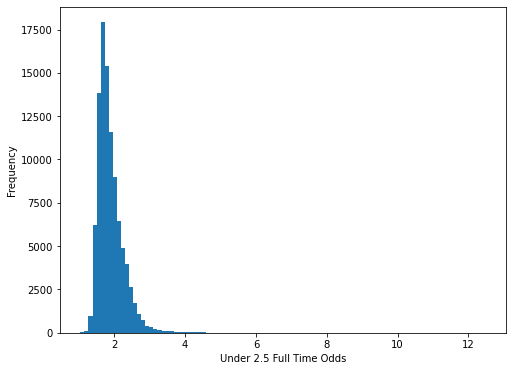

Column 'Over 3.5 Full Time Odds' is not normally distributed (p-value: 0.0000)


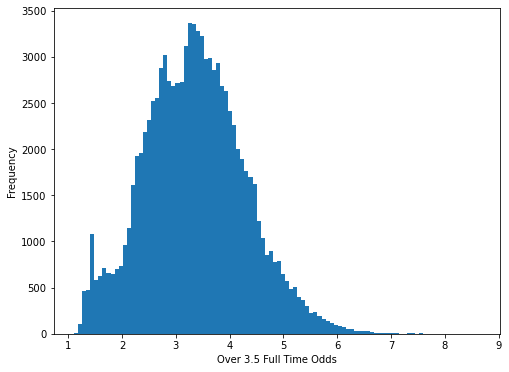

Column 'Under 3.5 Full Time Odds' is not normally distributed (p-value: 0.0000)


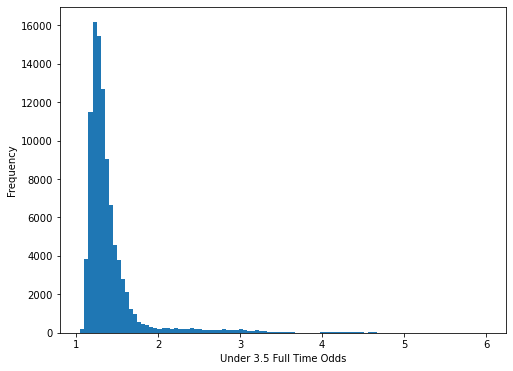

Column 'Home DC Team Full Time Odds' is not normally distributed (p-value: 0.0000)


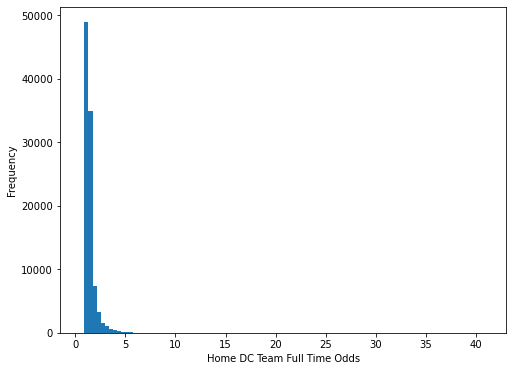

Column 'Either Full Time Odds' is not normally distributed (p-value: 0.0000)


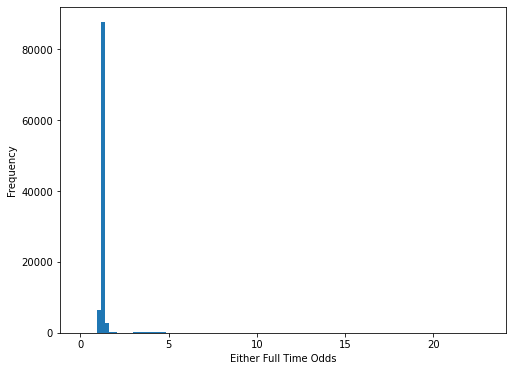

Column 'Away DC Team Full Time Odds' is not normally distributed (p-value: 0.0000)


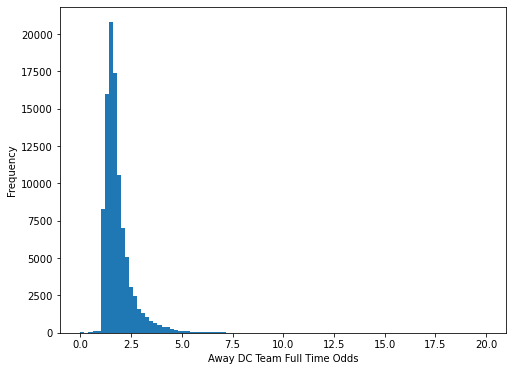

Column 'Home DNB Team Full Time Odds' is not normally distributed (p-value: 0.0000)


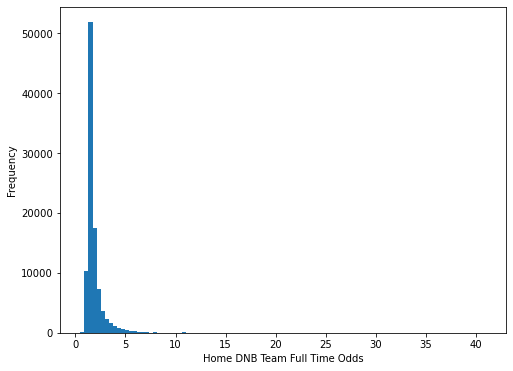

Column 'Either DNB Full Time Odds' is not normally distributed (p-value: 0.0000)


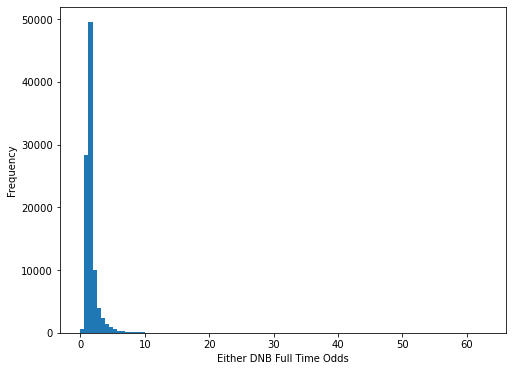

Column 'Away DNB Team Full Time Odds' is not normally distributed (p-value: 0.0000)


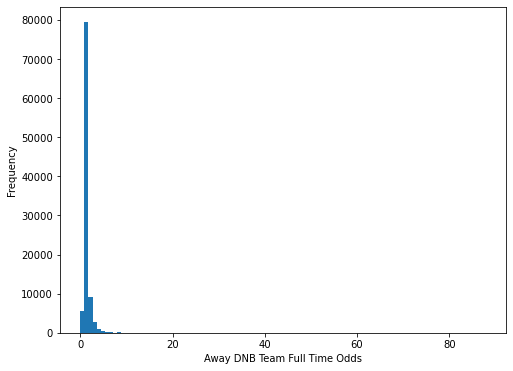

Column 'BTS Yes Full Time Odds' is not normally distributed (p-value: 0.0000)


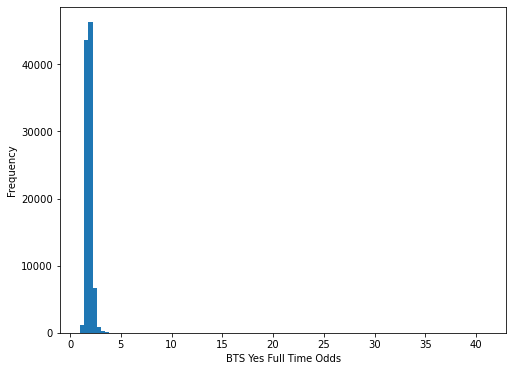

Column 'BTS No Full Time Odds' is not normally distributed (p-value: 0.0000)


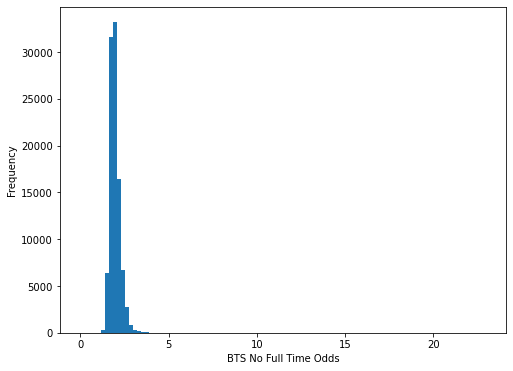

Column 'ts' is not normally distributed (p-value: 0.0000)


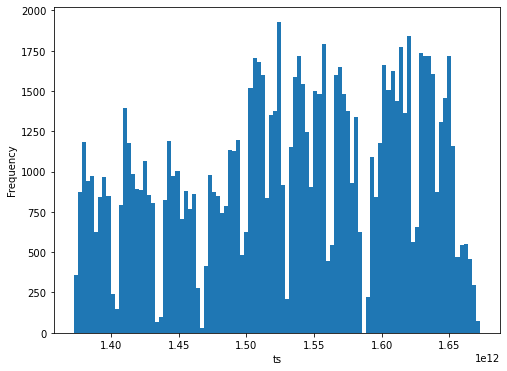

In [38]:
for col in df.columns[:-6]:
    if df[col].dtype in ['float64', 'int64']:
        vals = df[col].dropna().values
        stat, p = shapiro(vals)
        alpha = 0.05
        if p > alpha:
            print(f"Column '{col}' is normally distributed (p-value: {p:.4f})")
        else:
            print(f"Column '{col}' is not normally distributed (p-value: {p:.4f})")
        plt.figure(figsize=(8, 6))
        x = df[col]
        plt.hist(x, bins=100)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

We cap extreme values in our dataset at the 99th percentile. 

In [39]:
for col in df.columns:
    if df[col].dtype in ['float64', 'int64'] and col != "ts" and not "Odds" in col:
        value_99 = df[col].quantile(0.99)
        df.loc[df[col] > value_99, col] = value_99

In [40]:
df_final = df.dropna()
df_final

,Match ID,Home Team,Away Team,Country,League,Kick Off,Home 1st Half Goals,Away 1st Half Goals,Home 2nd Half Goals,Away 2nd Half Goals,...,away_win,draw,o25,bts,o15,home_goal,away_goal,home_dc,either_dc,away_dc
35401,g_1_8YTbqtc7,Shirak Gyumri,Tre Penne,EUROPE,EUROPE: Champions League,2013-07-02 14:00:00,1.0,0.0,2.0,0.0,...,0,0,1,0,1,1,0,1,1,0
37193,g_1_vcrck9iH,Met. Skopje,Qarabag,EUROPE,EUROPE: Europa League,2013-07-02 16:45:00,0.0,0.0,0.0,1.0,...,1,0,0,0,0,0,1,0,1,1
37253,g_1_6V4GxW7B,Sliema,Khazar Lenkoran,EUROPE,EUROPE: Europa League,2013-07-02 16:45:00,0.0,1.0,1.0,0.0,...,0,1,0,1,1,1,1,1,0,1
37416,g_1_A3B7vhwa,Narva,Gefle,EUROPE,EUROPE: Europa League,2013-07-02 17:00:00,0.0,1.0,0.0,2.0,...,1,0,1,0,1,0,1,0,1,1
35375,g_1_nPS2r0CD,Lusitanos,Streymur,EUROPE,EUROPE: Champions League,2013-07-02 18:30:00,2.0,0.0,0.0,2.0,...,0,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7502,g_1_M1wwMznM,Meizhou Hakka,Guangzhou FC,CHINA,CHINA: Super League,2022-12-31 07:00:00,0.0,0.0,1.0,0.0,...,0,0,0,0,0,1,0,1,1,0
7249,g_1_WzTCFYOk,Guangzhou City,Cangzhou,CHINA,CHINA: Super League,2022-12-31 07:00:00,0.0,3.0,1.0,0.0,...,1,0,1,1,1,1,1,0,1,1
7266,g_1_z5ssLf1S,Chengdu Rongcheng,Dalian Pro,CHINA,CHINA: Super League,2022-12-31 07:00:00,1.0,0.0,2.0,0.0,...,0,0,1,0,1,1,0,1,1,0
7310,g_1_jwqEDCg2,Shanghai Port,Changchun Yatai,CHINA,CHINA: Super League,2022-12-31 07:00:00,3.0,0.0,0.0,0.0,...,0,0,1,0,1,1,0,1,1,0


We have a final dataframe that we can use for feature engineering. We have a dropped over 7000 games from our dataframe. Most importantly, we have preserved the overwhelming majority of games in the biggest leagues.

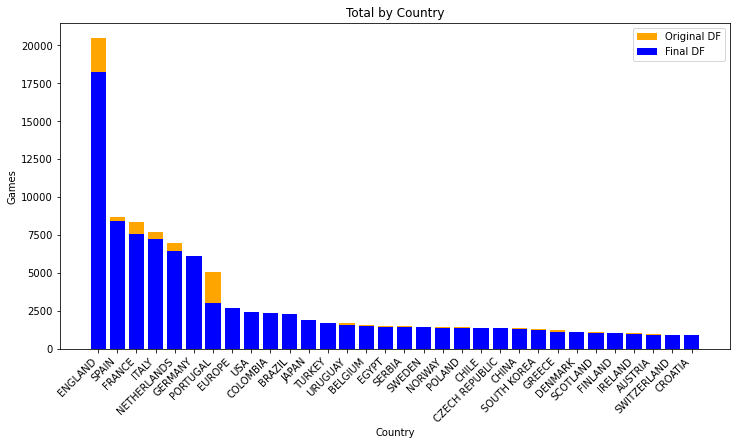

In [43]:
games_by_country_original = df['Country'].value_counts().sort_values(ascending=False)

games_by_country_final = df_final['Country'].value_counts().sort_values(ascending=False)
countries_original = games_by_country_original.index.tolist()
game_counts_original = games_by_country_original.values.tolist()
countries_final = games_by_country_final.index.tolist()
game_counts_final = games_by_country_final.values.tolist()


plt.figure(figsize=(12, 6))
plt.bar(range(len(game_counts_original)), game_counts_original, color='orange', label='Original DF')
plt.bar(range(len(game_counts_final)), game_counts_final, color='blue', label='Final DF')
plt.xticks(range(len(countries_original)), countries_original, rotation=45, ha='right')
plt.xlabel('Country')
plt.ylabel('Games')
plt.title('Total by Country')

plt.legend()
plt.show()

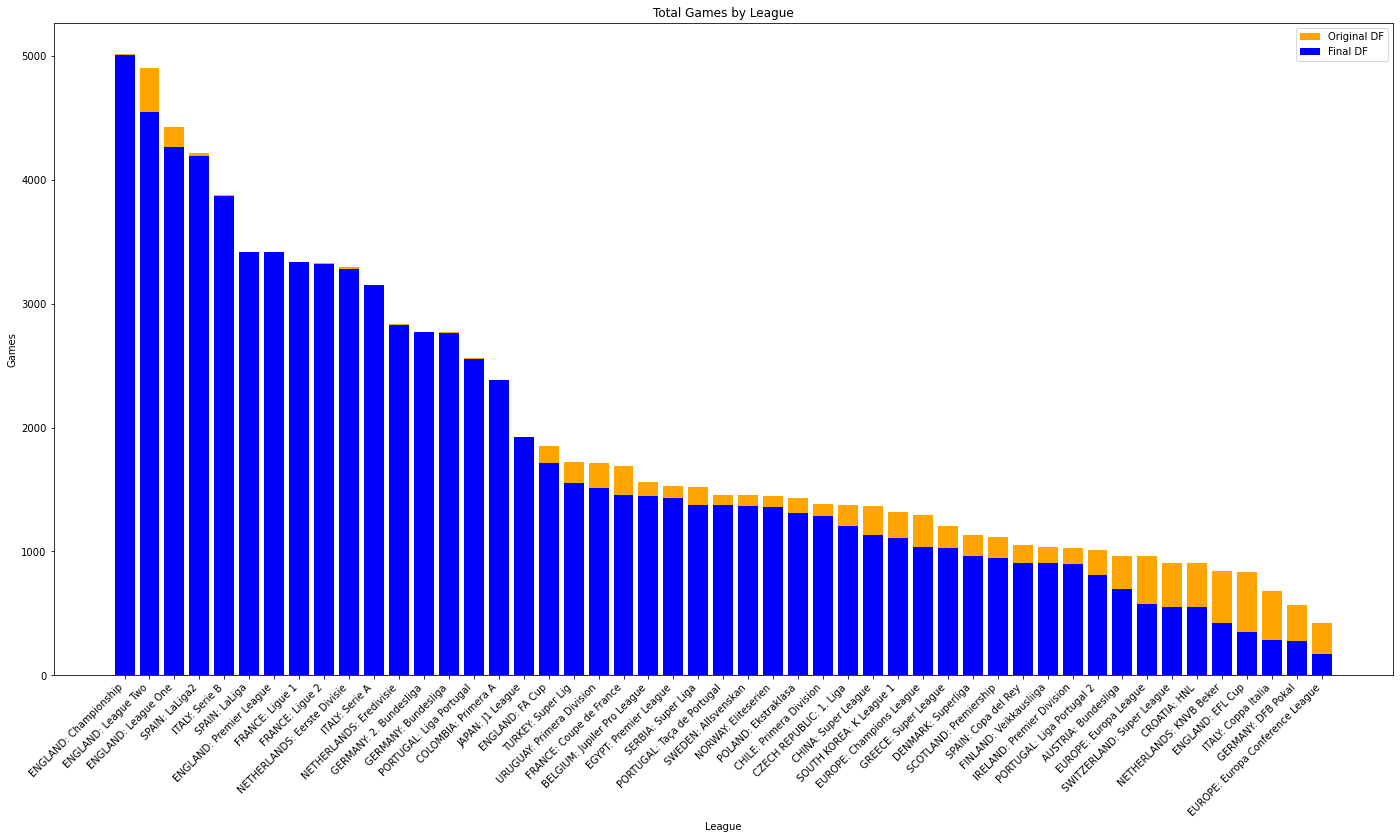

In [44]:
games_by_league_original = df['League'].value_counts().sort_values(ascending=False)
games_by_league_final = df_final['League'].value_counts().sort_values(ascending=False)

leagues_original = games_by_league_original.index.tolist()
game_counts_original = games_by_league_original.values.tolist()

leagues_final = games_by_league_final.index.tolist()
game_counts_final = games_by_league_final.values.tolist()

unequal_indices = [i for i in range(len(game_counts_original)) if game_counts_original[i] != game_counts_final[i]]
unequal_leagues_original = [leagues_original[i] for i in unequal_indices]
unequal_counts_original = [game_counts_original[i] for i in unequal_indices]
unequal_counts_final = [game_counts_final[i] for i in unequal_indices]

plt.figure(figsize=(24, 12))

plt.bar(range(len(unequal_counts_original)), unequal_counts_original, color='orange', label='Original DF')
plt.bar(range(len(unequal_counts_final)), unequal_counts_final, color='blue', label='Final DF')
plt.xticks(range(len(unequal_counts_original)), unequal_leagues_original, rotation=45, ha='right')

plt.xlabel('League')
plt.ylabel('Games')
plt.title('Total Games by League')

plt.legend()
plt.show()

Finally we will investigate the presence of heteroscedasticity on our dataset. We will reference this later when conducting PCA.

In [45]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df2 = df.replace([np.inf, -np.inf], np.nan).dropna()

for col in df2.columns[:-6]:
    if df2[col].dtype in ['float64', 'int64']:
        y = df2[col].values
        X = df2[numeric_cols]
        X = X.drop(col, axis=1).values
        _, p, _, _ = het_breuschpagan(y, X)
        alpha = 0.05
        if p > alpha:
            print(f"Column '{col}' does not exhibit heteroscedasticity (p-value: {p:.4f})")
        else:
            print(f"Column '{col}' exhibits heteroscedasticity (p-value: {p:.4f})")

Column 'Home 1st Half Goals' exhibits heteroscedasticity (p-value: 0.0000)
Column 'Away 1st Half Goals' exhibits heteroscedasticity (p-value: 0.0000)
Column 'Home 2nd Half Goals' exhibits heteroscedasticity (p-value: 0.0000)
Column 'Away 2nd Half Goals' exhibits heteroscedasticity (p-value: 0.0000)
Column 'Home Score' exhibits heteroscedasticity (p-value: 0.0000)
Column 'Away Score' exhibits heteroscedasticity (p-value: 0.0000)
Column 'Home Team Match Goal Attempts' exhibits heteroscedasticity (p-value: 0.0000)
Column 'Away Team Match Goal Attempts' exhibits heteroscedasticity (p-value: 0.0000)
Column 'Home Team Match Shots on Goal' exhibits heteroscedasticity (p-value: 0.0000)
Column 'Away Team Match Shots on Goal' exhibits heteroscedasticity (p-value: 0.0000)
Column 'Home Team Match Shots off Goal' exhibits heteroscedasticity (p-value: 0.0000)
Column 'Away Team Match Shots off Goal' exhibits heteroscedasticity (p-value: 0.0000)
Column 'Home Team Match Corner Kicks' exhibits heterosce

In this notebook, we have put together a dataframe from our scraped flashscore soccer data. We have investigated missing values and imputed them, and investigated data inconsistencies. We undertook basic processing and cleaning steps and looked at the distribution of our variables. We also checked for multicollinearity. We have ended up with a much better understanding of our data, and a final dataframe with over 90% of the original rows still intact. This leaves us with over 90k observations to train a preditive model on. 

In the next notebook, we will be engineering various ratings/rankings features and comparing their performance in a single-variable logistic regression model. There will be an EDA conducted on these features also.

In [46]:
df.to_csv(r"soccer_df.csv")